# Regression Analysis of the Hotel Customer Dataset
**Evamaria Saunders** <br>
**28/11/2021** <br>
**Dataset**: https://www.kaggle.com/nantonio/a-hotels-customers-dataset?resource=download <br>
*More Information*: https://www.sciencedirect.com/science/article/pii/S2352340920314645?via%3Dihub <br>

<br>

## Part 1: Pre-Processing

In [181]:
#import relevant libraries/packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests

#libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.gofplots as sgg
import statsmodels.stats as stats 
import statsmodels.tools.eval_measures as ste
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#settings for displaying tables/dataframes
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)

#set plot style
plt.style.use("seaborn")

In [110]:
file_dir = "C:/Users/Computer/Documents/Evamaria's Documents/Personal Projects/Data/HotelCustomersDataset.xlsx"
dataset = pd.read_excel(file_dir)

### Part 1.1: Missing Values
In this case, the only variable with obvious missing values is Age. After further exploration, there might be an underlying pattern that distinguishes customers with and without a reported age. Most notably, there are some differences in terms of the Days Since Creation and the Lodging Revenue. At this point, it is unclear whether there is any truth to this pattern or if missing age values are not systematic after all. In general, less than 5% of age values are missing. Based on this, two options are possible: (1) due to the relatively small number of affected customers, exclude these cases under the assumption that there is no systematic reason behind this and that future analyses will not be negatively affected by excluding said customers; or (2) use a systematic manner of replacing said missing values, for instance kNN. For the next parts, no decision will be made on this matter. 

In [111]:
#explore which variables have missing values
dataset.isnull().apply(lambda x:x.value_counts())

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,...,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
False,83590.0,83590.0,79811,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,...,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0,83590.0
True,NaN,NaN,3779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
#explore whether customers with missing values for age are different from other customers
dataset[dataset["Age"].isnull()].describe()

,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
count,3779.000000,0.0,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.0,3779.000000,3779.0,3779.000000
mean,30564.220164,NaN,604.807356,53.236306,227.895337,59.834678,0.005822,0.001852,0.829849,3.609950,1.983858,543.764488,547.921937,0.030431,0.000529,0.000529,0.000794,0.001323,0.000265,0.009791,0.254035,0.123842,0.0,0.002117,0.0,0.035194
std,23879.422399,NaN,332.874209,81.668457,457.564384,145.264834,0.082753,0.048773,0.799615,3.993015,3.617059,388.656711,389.194374,0.171794,0.023002,0.023002,0.028168,0.036355,0.016267,0.098477,0.435375,0.329445,0.0,0.045968,0.0,0.184295
min,2.000000,NaN,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
25%,8717.500000,NaN,288.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,127.000000,134.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
50%,25658.000000,NaN,633.000000,13.000000,144.500000,27.000000,0.000000,0.000000,1.000000,2.000000,2.000000,588.000000,594.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
75%,49072.500000,NaN,922.000000,76.000000,295.500000,68.500000,0.000000,0.000000,1.000000,6.000000,3.000000,920.000000,920.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000
max,83536.000000,NaN,1095.000000,588.000000,21781.000000,5105.500000,2.000000,2.000000,29.000000,62.000000,185.000000,1100.000000,1186.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000


In [113]:
dataset[dataset["Age"].notnull()].describe()

,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
count,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000,79811.000000
mean,42327.293944,45.398028,446.483267,66.809663,302.159477,67.956300,0.001842,0.000576,0.792948,4.698337,2.376276,394.310509,396.503577,0.048289,0.001453,0.000238,0.000877,0.002919,0.001779,0.013382,0.357357,0.143426,0.000351,0.003571,0.000125,0.090890
std,24012.564901,16.572368,310.620996,87.990086,368.022975,112.640373,0.065912,0.028312,0.690435,4.587289,2.196953,343.655426,344.398535,0.214378,0.038096,0.015428,0.029603,0.053953,0.042143,0.114903,0.479224,0.350509,0.018727,0.059651,0.011193,0.287454
min,1.000000,-11.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21680.500000,34.000000,174.000000,0.000000,64.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,25.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42383.000000,46.000000,385.000000,30.000000,236.000000,39.800000,0.000000,0.000000,1.000000,4.000000,2.000000,350.000000,357.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,63194.500000,57.000000,703.000000,104.000000,407.000000,88.500000,0.000000,0.000000,1.000000,8.000000,4.000000,678.000000,682.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,83590.000000,122.000000,1095.000000,588.000000,9682.400000,7730.250000,9.000000,3.000000,66.000000,116.000000,116.000000,1104.000000,1117.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


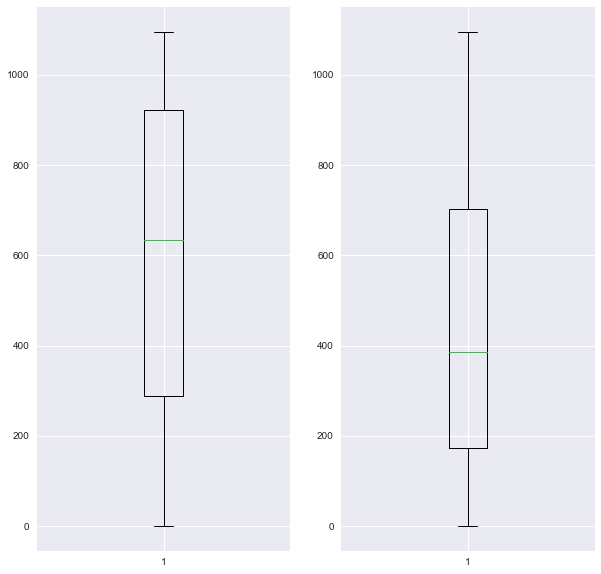

In [114]:
#difference in Days Since Creation
figure, axis = plt.subplots(1,2, figsize=(10,10))
axis[0].boxplot(dataset["DaysSinceCreation"][dataset["Age"].isnull()])
axis[1].boxplot(dataset["DaysSinceCreation"][dataset["Age"].notnull()])
plt.show()

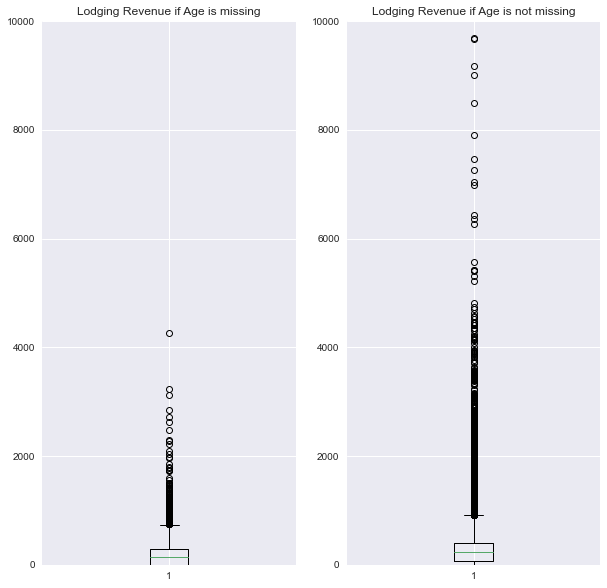

In [115]:
#Difference in Lodging Revevenue (after excluding one major outlier)
figure, axis = plt.subplots(1,2, figsize=(10,10))
axis[0].boxplot(dataset["LodgingRevenue"][dataset["Age"].isnull()])
axis[0].set_ylim(0,10000)
axis[0].set_title("Lodging Revenue if Age is missing")

axis[1].boxplot(dataset["LodgingRevenue"][dataset["Age"].notnull()])
axis[1].set_ylim(0,10000)
axis[1].set_title("Lodging Revenue if Age is not missing")

plt.show()

In [116]:
#how often is Age missing among customers that never completed a booking?
print(dataset["Age"][(dataset["BookingsCanceled"] == 0) & (dataset["BookingsNoShowed"] == 0) & (dataset["BookingsCheckedIn"] == 0)].isnull().value_counts())

#how often is Age missing among customers that completed at least one booking?
print(dataset["Age"][(dataset["BookingsCanceled"] > 0) | (dataset["BookingsNoShowed"] > 0) | (dataset["BookingsCheckedIn"] > 0)].isnull().value_counts())

False    19070
True       849
Name: Age, dtype: int64
False    60741
True      2930
Name: Age, dtype: int64


### Part 1.2: Outliers
Examing the different variables, both outliers based on which values are meaningful as well as based on statistical criteria could be identified. The criteria used to consider values as outliers is 3SD above (or below) the mean. 

Firstly, there are several customers with a negative value for age. As this value is often below 10, it seems unlikely that the minus was a mistake. These customers will be excluded. 
Moreover, there are several customers with age above 100 years. As very few individuals reach this age and no one over the age of 118 has been recorded in the last century, these age values certainly extreme and possibly false and these customers will be excluded. 

Secondly, for 19920 customers the Days Since Last and First Stay has the value -1. It appears that this was used to mark customers that never completed a booking. 

Thirdly, for ten customers the average lead time was below -1. This could represent a missing value. Since this is only thecase for very few customers, exclusion is the easiest solution. In contrast, the large number of customers with a rather large average lead time are harder to deal with. As the distribution of these customers is rather uniform, determining which ones to exclude is difficult.

Forthly, there are certainly several outliers for the three booking outcome variables. As these three variables could be considered unary variables, the outliers and general issue will be dealt with as follows: create two new variables, namely a boolean Multiple Bookings ("One", "More than One") and a boolean OtherOutcome("Cancelled/NoShow" - True/False). In order for this to work, customers without any bookings will be excluded. This makes sense since predicting revenue will not work for customers that yielded no revenue. 

Fifthly, for both types of revenue customers above a specified value will be excluded as their extreme outliers might skew the data too much. These values were chosen based on the graphs and are as follows: 5000 for lodging revenue, and 2000 for other revenue. 

Sixtly, in a similar fashion several customers will be excluded based on extremely high values for Room Nights or Persons Nights, specifically above 30 and 40, respectively. 

Seventhly, in hindsight the two variables Distribution Channel and Market Segment might not have any obvious outliers, but the overlapping and imbalanced distributions are could cause issues. Consequently, these variables will be combined using the most common shared categories, while excluding the rarest categories. 

For the remaining variables, no outliers were detected. 

After the modeling phase, the topic of outliers will be revisited from a model perspective. 

In [117]:
#examine the least common nationality values to see if there are possible outliers
dataset["Nationality"].value_counts()[-25:]

DMA    1
IOT    1
TZA    1
MMR    1
FRO    1
NCL    1
GNQ    1
NPL    1
SOM    1
VIR    1
PCN    1
ZWE    1
TMP    1
NRU    1
WSM    1
TKM    1
LCA    1
PNG    1
SWZ    1
YEM    1
VCT    1
BHS    1
TON    1
JEY    1
GIN    1
Name: Nationality, dtype: int64

In [118]:
#explore age outliers
dataset[(dataset["Age"] < 0) | (dataset["Age"] > (3 * dataset["Age"].std() + dataset["Age"].mean()))]

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,...,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
2053,2054,BIH,-7.0,1034,0x816353557EFCF6A1E3FF64F3D652A18AE9F7EC0011E3...,0xE2B44FF02C72B0234AFA04D4BA9C7889491F302A9963...,0,0.00,0.00,0,0,0,0,0,-1,...,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
2469,2470,ATF,-7.0,1029,0x05640BCB4A2D55CFDB6FB9615FD588A68C333119BC5F...,0x169E79749C1DD48C3510BEDBC69DD0DC9E0BDEF72B9C...,0,0.00,0.00,0,0,0,0,0,-1,...,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
3282,3283,PRT,114.0,1015,0xD38D7A36180C13A0574D7519E1494B8E2EAC72621A6D...,0xCF11B7A6F80F424EDB78D3FF8352233D36F6F511F9B6...,22,79.00,25.50,0,0,1,2,1,1016,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,1,0,0,0,0,0
5128,5129,FRA,-9.0,981,0x6471098D9873D3D9CE70D2456C07F63B3359B270A5DE...,0x28EE0D2DD37EC913224737D542F8B9B6F30794306710...,66,93.30,14.00,0,0,1,2,1,982,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,1,0,0,0,0,0
6751,6752,GBR,-11.0,953,0xDB672419DADD95C4603D3210DCD2722B008DEBD1C69F...,0xB8599D349F3951EF4D29B6F03E4EB0E22ADEC4105246...,22,450.00,18.00,0,0,1,1,1,954,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,1,0,0,0,0,0
8360,8361,DEU,-7.0,927,0x72A31262A688A38B139A9914054C3BEFF00BC4C4DE8C...,0x539E60160A1B4C94C61F0066A4F784C2BB6570181BF3...,256,126.00,109.00,0,0,1,4,2,929,...,Travel Agent/Operator,Groups,0,0,0,0,0,0,0,0,1,0,0,0,0
8628,8629,NLD,-10.0,923,0xF5C3782374B119A5B043FFE67A40DF8D7C8DD9FA66BB...,0xB0B8AE3BFF0FFAF09432A12D497EEFB52EB855BFE553...,111,414.60,34.00,0,0,1,4,4,927,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,1,0,0,0,0,0
9919,9920,DZA,-6.0,903,0x8106B7FC258F07571A74AAC617DA57DFB039C4E07116...,0xCACE52DD1FFE1D9AC33DCA72A6D532DC4EDEB132294C...,54,138.93,29.50,0,0,1,4,1,904,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,1,0,0,0,0,0
10662,10663,DEU,-10.0,891,0x77AF5AA2214FAAC110FCAA4BF988531CCF9742848A02...,0x4AFD6241BBBC6116AB5310415050347D9353661E23BC...,292,126.00,113.00,0,0,1,4,2,893,...,Travel Agent/Operator,Groups,0,0,0,0,0,0,0,0,0,0,0,0,0
10694,10695,DEU,-10.0,891,0x89B606A6E3FD4FBA4AA9FD5D3E552261DB8CC434F8E4...,0xD50637C1BADB59272CC168B25157C49E0E7BB82B3373...,292,128.00,57.50,0,0,1,2,2,893,...,Travel Agent/Operator,Groups,0,0,0,0,0,0,0,0,0,0,0,0,0


In [119]:
#customers with values below 0
print((dataset["DaysSinceCreation"] < 0).value_counts())
print((dataset["DaysSinceLastStay"] < 0).value_counts())
print((dataset["DaysSinceFirstStay"] < 0).value_counts())

#customers with values +3SD or more above the mean
print(len(dataset["DaysSinceCreation"][dataset["DaysSinceCreation"] > (3 * dataset["DaysSinceCreation"].std() + dataset["DaysSinceCreation"].mean())]))
print(len(dataset["DaysSinceFirstStay"][dataset["DaysSinceFirstStay"] > (3 * dataset["DaysSinceFirstStay"].std() + dataset["DaysSinceFirstStay"].mean())]))
print(len(dataset["DaysSinceFirstStay"][dataset["DaysSinceFirstStay"] > (3 * dataset["DaysSinceFirstStay"].std() + dataset["DaysSinceFirstStay"].mean())]))

False    83590
Name: DaysSinceCreation, dtype: int64
False    63670
True     19920
Name: DaysSinceLastStay, dtype: int64
False    63670
True     19920
Name: DaysSinceFirstStay, dtype: int64
0
0
0


In [120]:
#customers with values below 0
print((dataset["AverageLeadTime"] < 0).value_counts())

#customers with values +3SD or more above the mean
print(len(dataset["AverageLeadTime"][dataset["AverageLeadTime"] > (3 * dataset["AverageLeadTime"].std() + dataset["AverageLeadTime"].mean())]))

False    83580
True        10
Name: AverageLeadTime, dtype: int64
1379


In [121]:
dataset[dataset["AverageLeadTime"] < 0]

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,...,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
23061,23062,PRT,NaN,674,0x950528CDB64433021300E90F82F0A488EE3D77975107...,0x5FA1E0098A31497057C5A6B9FE9D49FD6DD47CCE7C26...,-1,352.00,30.0,0,0,1,2,1,675,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
29370,29371,USA,24.0,580,0x45F7145C9756209F4516792A12405BCF80F0CA11C9DA...,0xBF7D0F7A307408DB6DF379DA51FCDD3CDE4BED55949B...,-1,77.49,3.0,0,0,1,3,1,581,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
51361,51362,CHN,32.0,268,0x1F272F052D5331199FA42B15CC3D61673248B3681AA5...,0xFEE3773458B225FE3801DCAE2A05B6555CBF3189BA6F...,-1,129.00,2.0,0,0,1,2,1,269,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
58639,58640,FRA,56.0,209,0xA9B2F0B5565363E5139FAB8B334CFAD53B6A4AA2C288...,0x9A65F4E43F686D03748C3D7A4B67E2147D0FE258C876...,-1,149.00,2.0,0,0,1,2,1,210,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
58646,58647,FRA,61.0,209,0x540543AB2CF737FA79CFF44288F339AD315418CA45B3...,0x6C029B2137E29E837182F75AE1A4E75C8362FB29F8DC...,-1,149.00,2.0,0,0,1,2,1,210,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
58660,58661,FRA,60.0,209,0xAC235F8012A830A8C10F2A5B2F0768B3A31FF909E99C...,0x5DD2CFBC8B0458DB9810532AE49BD01082D14704FC40...,-1,149.00,2.0,0,0,1,2,1,210,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
60574,60575,ESP,45.0,195,0xE78ACF1238CDD93FE7F7427757C35B109E7477D87A1B...,0x41A4B91A984EB68C9D465F184A5C8EBB2196E7DF5B77...,-1,159.00,2.0,0,0,1,2,1,196,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
62673,62674,USA,69.0,178,0x80E6939CD6CB5B0150D97670C19F4CAD17D9283944EC...,0x4EF4596897E1BA99E3B28B0FF8A67E86F87CC0E8FEA3...,-1,95.20,2.0,0,0,1,2,1,179,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
68469,68470,GBR,45.0,134,0x53A6D7D4B9E9799A8CBE5F05E83BEDC9673838DA4A5E...,0xF546FA5913D1B0AC53428DFCEC5E5AEE1CC45F55C252...,-1,282.00,24.0,0,0,1,4,1,135,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
72692,72693,BRA,30.0,104,0xBA8138E4B688037A2DCC39759960D57D6A633E5941F7...,0xE9C4A25F17D1199C2B82249C09C6201E67ABBBDA4439...,-1,209.00,2.0,0,0,1,2,1,105,...,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0


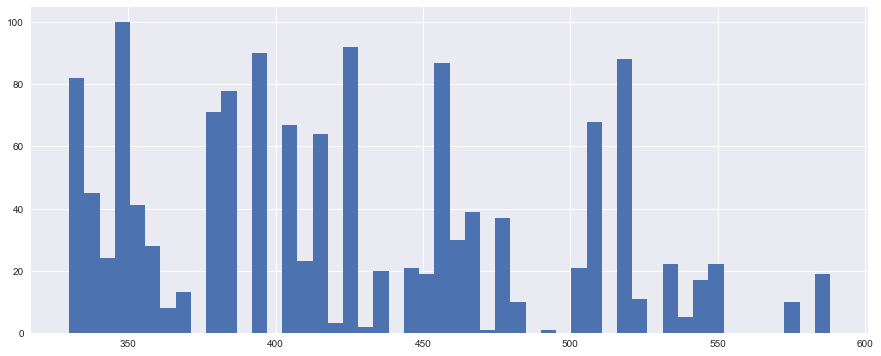

In [122]:
#visualising the distributions of AverageLeadTime for these customers
plt.figure(figsize = (15,6))
plt.hist(dataset["AverageLeadTime"][dataset["AverageLeadTime"] > (3 * dataset["AverageLeadTime"].std() + dataset["AverageLeadTime"].mean())],50)
plt.show()

In [123]:
#customers with values below 0
print((dataset["BookingsCanceled"] < 0).value_counts())
print((dataset["BookingsNoShowed"] < 0).value_counts())
print((dataset["BookingsCheckedIn"] < 0).value_counts())

#customers with values +3SD or more above the mean
print(len(dataset["BookingsCanceled"][dataset["BookingsCanceled"] > (3 * dataset["BookingsCanceled"].std() + dataset["BookingsCanceled"].mean())]))
print(len(dataset["BookingsNoShowed"][dataset["BookingsNoShowed"] > (3 * dataset["BookingsNoShowed"].std() + dataset["BookingsNoShowed"].mean())]))
print(len(dataset["BookingsCheckedIn"][dataset["BookingsCheckedIn"] > (3 * dataset["BookingsCheckedIn"].std() + dataset["BookingsCheckedIn"].mean())]))

False    83590
Name: BookingsCanceled, dtype: int64
False    83590
Name: BookingsNoShowed, dtype: int64
False    83590
Name: BookingsCheckedIn, dtype: int64
118
44
308


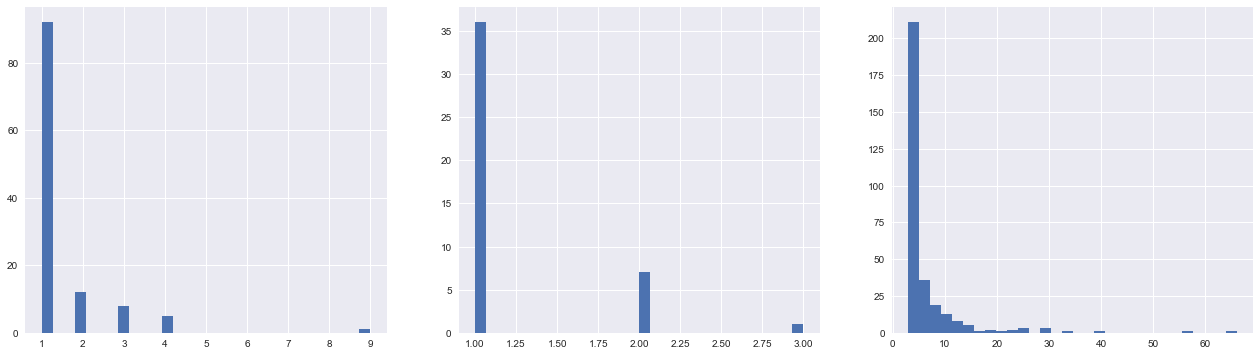

In [124]:
#visualising the distributions of Bookings Canceled, Bookings No Showed and Bookings Checked In for these customers
figure, axis = plt.subplots(1,3, figsize = (22,6))
axis[0].hist(dataset["BookingsCanceled"][dataset["BookingsCanceled"] > (3 * dataset["BookingsCanceled"].std() + dataset["BookingsCanceled"].mean())],30)
axis[1].hist(dataset["BookingsNoShowed"][dataset["BookingsNoShowed"] > (3 * dataset["BookingsNoShowed"].std() + dataset["BookingsNoShowed"].mean())],30)
axis[2].hist(dataset["BookingsCheckedIn"][dataset["BookingsCheckedIn"] > (3 * dataset["BookingsCheckedIn"].std() + dataset["BookingsCheckedIn"].mean())],30)
plt.show()

In [125]:
#customers with values below 0
print((dataset["LodgingRevenue"] < 0).value_counts())
print((dataset["OtherRevenue"] < 0).value_counts())

#customers with values +3SD or more above the mean
print(len(dataset["LodgingRevenue"][dataset["LodgingRevenue"] > (3 * dataset["LodgingRevenue"].std() + dataset["LodgingRevenue"].mean())]))
print(len(dataset["OtherRevenue"][dataset["OtherRevenue"] > (3 * dataset["OtherRevenue"].std() + dataset["OtherRevenue"].mean())]))

False    83590
Name: LodgingRevenue, dtype: int64
False    83590
Name: OtherRevenue, dtype: int64
1364
1230


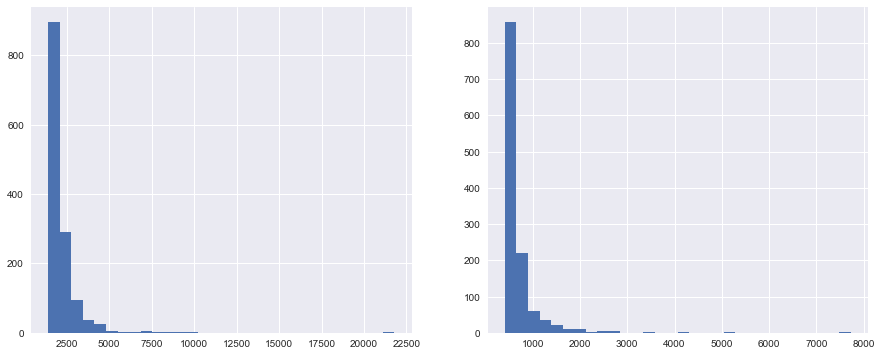

In [126]:
#visualising the distributions of Lodging Revenue and Other Revenue for these customers
figure, axis = plt.subplots(1,2, figsize = (15,6))
axis[0].hist(dataset["LodgingRevenue"][dataset["LodgingRevenue"] > (3 * dataset["LodgingRevenue"].std() + dataset["LodgingRevenue"].mean())],30)
axis[1].hist(dataset["OtherRevenue"][dataset["OtherRevenue"] > (3 * dataset["OtherRevenue"].std() + dataset["OtherRevenue"].mean())],30)
plt.show()

In [127]:
#customers with values below 0
print((dataset["RoomNights"] < 0).value_counts())
print((dataset["PersonsNights"] < 0).value_counts())

#customers with values +3SD or more above the mean
print(len(dataset["RoomNights"][dataset["RoomNights"] > (3 * dataset["RoomNights"].std() + dataset["RoomNights"].mean())]))
print(len(dataset["PersonsNights"][dataset["PersonsNights"] > (3 * dataset["PersonsNights"].std() + dataset["PersonsNights"].mean())]))

False    83590
Name: RoomNights, dtype: int64
False    83590
Name: PersonsNights, dtype: int64
457
990


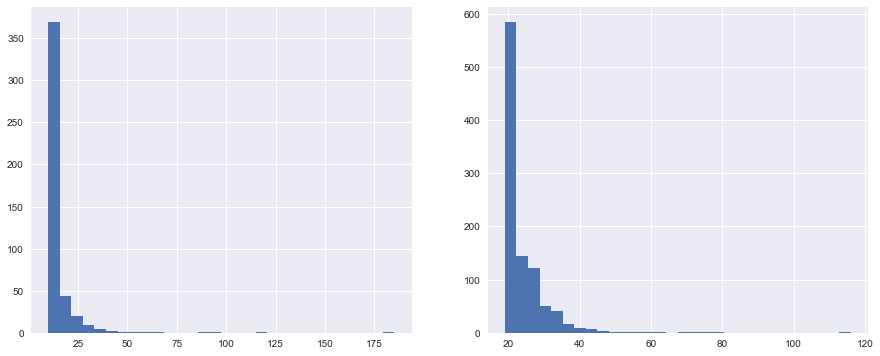

In [128]:
#visualising the distributions of Room Nights and Persons Nights for these customers
figure, axis = plt.subplots(1,2, figsize = (15,6))
axis[0].hist(dataset["RoomNights"][dataset["RoomNights"] > (3 * dataset["RoomNights"].std() + dataset["RoomNights"].mean())],30)
axis[1].hist(dataset["PersonsNights"][dataset["PersonsNights"] > (3 * dataset["PersonsNights"].std() + dataset["PersonsNights"].mean())],30)
plt.show()

In [129]:
#examining the DistributionChannel & MarketSegment -> earlier descriptive statistics showed all unique values for these variables which were all regular   
#however, in hindsight these variables both have a very imbalanced distribution and a large amount of overlap
pd.crosstab(dataset["MarketSegment"], dataset["DistributionChannel"])

DistributionChannel,Corporate,Direct,Electronic Distribution,Travel Agent/Operator
MarketSegment,,,,
Aviation,239,0,0,5
Complementary,14,393,0,103
Corporate,1724,46,2,397
Direct,14,11219,5,219
Groups,478,134,1,8888
Other,34,96,496,47413
Travel Agent/Operator,97,24,5,11544


In [130]:
#examining all preference variables (booleans)
print((dataset[["SRHighFloor", "SRLowFloor", "SRAccessibleRoom", "SRMediumFloor", "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed", "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"]] < 0).value_counts())
print((dataset[["SRHighFloor", "SRLowFloor", "SRAccessibleRoom", "SRMediumFloor", "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed", "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"]] > 1).value_counts())

SRHighFloor  SRLowFloor  SRAccessibleRoom  SRMediumFloor  SRBathtub  SRShower  SRCrib  SRKingSizeBed  SRTwinBed  SRNearElevator  SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom
False        False       False             False          False      False     False   False          False      False           False               False                 False          83590
dtype: int64
SRHighFloor  SRLowFloor  SRAccessibleRoom  SRMediumFloor  SRBathtub  SRShower  SRCrib  SRKingSizeBed  SRTwinBed  SRNearElevator  SRAwayFromElevator  SRNoAlcoholInMiniBar  SRQuietRoom
False        False       False             False          False      False     False   False          False      False           False               False                 False          83590
dtype: int64


### Part 1.3: Feature Engineering
#### Part 1.3.1 Create a Continent Variable based on Nationality
The nationality variable has a large number of categories and most of these categories only include a very small number of customers. While target-based encoding would avoid the issue of having a large number of dummy variables it does not solve the issue of the imbalanced distribution of customers across the nationalities. Instead, the first solution will be to create a continent variable as this will be easier to represent using dummies and hopefully show a less imbalanced distribution. 
Unfortunately, creating said continent variable shows that the imbalance remains with the majority of customers coming (unsurprisingly) from Europe. Futhermore, among the customers coming from Europe there are still a large number of countries which are rarely represented. 
<br>
To make this variable that represents customers origin more useful for future analyses, the adjusted plan is as follows: represent countries outside of Europe by the continent they are in; for countries within Europe, summarise the less common ones under "OtherEurope". The criteria for which countries within Europe will remain, will be 1000 customers. As this new variable ("Origin") will still have a decent number of categories, the final step will be to use target-based encoding. As total revenue will be the target of the regression analysis, each category will be replaced by the group mean value of this category. 


In [131]:
#import a country and continent codes list
#https://medium.com/towards-entrepreneurship/importing-a-csv-file-from-github-in-a-jupyter-notebook-e2c28e7e74a5
url = "https://gist.githubusercontent.com/stevewithington/20a69c0b6d2ff846ea5d35e5fc47f26c/raw/13716ceb2f22b5643ce5e7039643c86a0e0c6da6/country-and-continent-codes-list-csv.csv"
download = requests.get(url).content

country_continent_df = pd.read_csv(io.StringIO(download.decode('utf-8')))
country_continent_df = country_continent_df.loc[:,["Three_Letter_Country_Code", "Continent_Name"]]
country_continent_df.columns = ["Nationality", "Continent"]

In [132]:
#8 countries in this list are represented twice with different continents assigned, which results in issues when attempting to merge
#for these eight countries, the "duplicate" will be manually removed
#note: these decisions are not based on much consideration of the geopolitical/cutlural/.... situation of these countries, which would exceed the scope of this project
print(country_continent_df["Nationality"].value_counts()[country_continent_df["Nationality"].value_counts() > 1])

#Europe > Asia: Turkey, Armenia, Georgia, Azerbaijan
#Asia > Europe: Russia, Cyprus, Kazakhstan
#North America > Oceania: United States Minor Outlying Islands
country_continent_df = country_continent_df.drop(country_continent_df.index[[17, 235, 84, 9, 191, 58, 116, 171]])

#check that it worked
print(country_continent_df["Nationality"].value_counts()[country_continent_df["Nationality"].value_counts() > 1])

AZE    2
RUS    2
GEO    2
ARM    2
UMI    2
CYP    2
TUR    2
KAZ    2
Name: Nationality, dtype: int64
Series([], Name: Nationality, dtype: int64)


In [133]:
#create a contintent variable
dataset = pd.merge(dataset, country_continent_df[["Nationality", "Continent"]], how = "left", left_on = "Nationality", right_on = "Nationality")

In [134]:
top_nat = dataset["Nationality"][dataset["Continent"] == "Europe"].value_counts()[dataset["Nationality"][dataset["Continent"] == "Europe"].value_counts() > 1000].index.tolist()

In [135]:
(dataset["Nationality"].isin(top_nat) == False).value_counts()

False    63842
True     19748
Name: Nationality, dtype: int64

In [136]:
#create "Origin" variable based on Nationality and Continent
conditions = [(dataset["Continent"] == "Europe") & (dataset["Nationality"].isin(top_nat)),
    (dataset["Continent"] == "Europe") & (dataset["Nationality"].isin(top_nat) == False),
    (dataset["Continent"] != "Europe")]

values = [dataset["Nationality"], "Europe_Other", dataset["Continent"]]
dataset.loc[:,"Origin"] = np.select(conditions, values)

In [137]:
dataset["Origin"].value_counts()

FRA              12422
PRT              11597
DEU              10232
GBR               8656
Europe_Other      5797
North America     5237
ESP               4902
Asia              3675
South America     3378
ITA               3365
BEL               3119
NLD               2725
CHE               2108
IRL               1996
AUT               1489
SWE               1231
Oceania            834
Africa             813
Antarctica          13
Name: Origin, dtype: int64

In [138]:
#check for missing values in the new variable
dataset[dataset["Origin"].isna()]

#drop the customer as the country does not exist in the list
dataset = dataset[dataset["Origin"].notna()].copy()

In [139]:
#create the target variable of the regression analyses
dataset.loc[:,"TotalRevenue"] = dataset.loc[:,"OtherRevenue"] + dataset.loc[:,"LodgingRevenue"]

In [140]:
#create a TargetOrigin variable with the group mean for each Origin category 
dataset.loc[:,"TargetOrigin"] = dataset["Origin"].map(dataset.groupby("Origin")["TotalRevenue"].mean())
dataset[["Origin", "TotalRevenue"]].groupby("Origin").mean()

,TotalRevenue
Origin,
AUT,386.247649
Africa,489.026814
Antarctica,156.553846
Asia,342.155369
BEL,420.000529
CHE,388.707723
DEU,375.188045
ESP,366.330100
Europe_Other,422.990345


#### Part 1.3.2 Create Additional Variables
Firstly, as mentioned two now variables will be created based on the three Booking outcome variables. The first variable will be a boolean MultipleBookings Variable with two categories: False (One Booking), True (More than one booking). As customers without bookings will be excluded for the prediction of revenue (since they brought in no revenue), these two categories will be sufficient. Before excluding this variable, a third temporary category ("None") will be used. The second variable will be a boolean NegativeOutcome variable with two categories: 1/True (has cancelled or not showed up at least once) and 0/False (never cancelled or no showed). 

Secondly, the preference variables are all bool and could generally remain as they are. However, most of them could be considered unary variables. This leaves two options: (a) creating a variable to represent the total number of preferences/a bool to present whether they usually voice preferences or not, or (b) keeping only the most common preferences and summing up the uncommon ones into "SROther". To maintain as much information as possible, this latter option will be chosen. 

Thirdly, since the target variable is the Total Revenue, it does not make sense to maintain the LOding and Other Revenue Variables in the dataset. However, it could be interesting to keep the ratio between these two in the form of the proportion of income resulting from lodging. Consequently, this variable will be created as well. 

Lastly, as mentioned the variables MarketSegment and Distribution Channel will be combined using the most common categories from the crosstab: Corporate&Corporate, Direct&Direct, Travel Agent & Travel Agent, Travel Agent & Group, Travel Agent & Other, and Rest. 

In [141]:
#categorical BookingsCheckedIn Variable 
conditions = [(dataset["BookingsCheckedIn"] == 0), (dataset["BookingsCheckedIn"] == 1), (dataset["BookingsCheckedIn"] > 1)]
values = ["None", 0, 1] #0 = One, 1 = More than One 

dataset["MultipleBookings"] = np.select(conditions, values)

In [142]:
#boolean NegativeOutcome variable
#this variable is still almost unary, so it is unclear whether it will be useful at all for future analyses 
condition = ((dataset["BookingsNoShowed"] > 0) | (dataset["BookingsCanceled"] > 0))
dataset["NegativeOutcome"] = np.where(condition, 1, 0) 

In [143]:
#summary variable for preferences
#SRKingSizeBed, SRTwinBed, SRQuietRoom, and SRHighFloor will remain as they are. The remaining bool preferences will be summed up into one. 
condition = ( (dataset["SRLowFloor"] > 0) | (dataset["SRAccessibleRoom"] > 0) | (dataset["SRMediumFloor"] > 0) | (dataset["SRBathtub"] > 0) | (dataset["SRShower"] > 0) | (dataset["SRCrib"] > 0) | (dataset["SRNearElevator"] > 0) | (dataset["SRAwayFromElevator"] > 0) |  (dataset["SRNoAlcoholInMiniBar"] > 0) ) 
 	 	 	 	
dataset["OtherPreferences"] = np.where(condition, 1, 0)

In [144]:
pd.crosstab(dataset["DistributionChannel"], dataset["MarketSegment"])

MarketSegment,Aviation,Complementary,Corporate,Direct,Groups,Other,Travel Agent/Operator
DistributionChannel,,,,,,,
Corporate,239,14,1724,14,478,34,97
Direct,0,393,46,11219,134,96,24
Electronic Distribution,0,0,2,5,1,496,5
Travel Agent/Operator,5,103,397,219,8888,47412,11544


In [145]:
#shared Market & Distribution variable
conditions = [
    (dataset["MarketSegment"] == "Corporate") & (dataset["DistributionChannel"] == "Corporate"), 
    (dataset["MarketSegment"] == "Direct") & (dataset["DistributionChannel"] == "Direct"),
    (dataset["MarketSegment"] == "Groups") & (dataset["DistributionChannel"] == "Travel Agent/Operator"),
    (dataset["MarketSegment"] == "Other") & (dataset["DistributionChannel"] == "Travel Agent/Operator"),
    (dataset["MarketSegment"] == "Travel Agent/Operator") & (dataset["DistributionChannel"] == "Travel Agent/Operator"),
]

values  = [
    "Corporate", 
    "Direct",
    "Groups & Travel Agent",
    "Other & Travel Agent",
    "Travel Agent"
]

dataset.loc[:, "MarketDistribution"] = np.select(conditions, values)

#add the final category 
dataset.loc[dataset[dataset["MarketDistribution"] == '0'].index, "MarketDistribution"] = "Rest"

In [146]:
#poportion of income from lodging variable
dataset.loc[:,"LodgingRevProp"] = (dataset.loc[:,"LodgingRevenue"]/dataset.loc[:,"TotalRevenue"]).fillna(0)

### Part 1.4 Exclusions & Final Touches
#### Part 1.4.1 Excluding Customers

In [147]:
#exclude customers that never completed a booking
regr_df = dataset[dataset["DaysSinceFirstStay"] != -1].copy()

#excluding customers with negative age or age above 100
regr_df = regr_df[((regr_df["Age"] >= 0) & (regr_df["Age"] < 100)) | (regr_df["Age"].isna())].copy()

#exclude customers where Average Lead Time is -1 
regr_df = regr_df[regr_df["AverageLeadTime"] >= 0].copy()

#excluding customers where lodging revenue is above 5000 or other revenue is above 2000
regr_df = regr_df[(regr_df["LodgingRevenue"] < 5000) & (regr_df["OtherRevenue"] < 2000)].copy()

#excluding customers with RoomNights above 30 or PersonNights above 40
regr_df = regr_df[(regr_df["RoomNights"] < 30) & (regr_df["PersonsNights"] < 40)].copy()

#exclude customers from Antarctica
regr_df = regr_df[(regr_df["Origin"] != "Antarctica")].copy()

#### Part 1.4.2 Excluding Columns

In [148]:
regr_df = regr_df.drop(["ID", "NameHash", "DocIDHash", "BookingsCheckedIn", "BookingsCanceled", "BookingsNoShowed", "Nationality", "DistributionChannel", "MarketSegment", "Continent", "LodgingRevenue", "OtherRevenue", "SRLowFloor", "SRAccessibleRoom", "SRMediumFloor", 	"SRBathtub", "SRShower", "SRCrib", "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "Origin"], axis = 1)

#### Part 1.4.3: Normalisations?
While the quantitative variables in this dataset were certainly not all perfectly normally disrtributed and instead often showed a skew to the right due to extreme outliers, due to the size of the dataset and the approximation of a ND, no quantitative variables will be transformed. 

#### Part 1.4.4: Multicollinearity? 
As a last step, the correlations between variables will be examined to ensure that multicollinearity will not be an issue. However, the visualised correlation matrix indicates otherwise.
Firstly, the three time related variables (DaysSinceCreation, DaysSinceFirstStay, DaysSinceLastStay) are (almost) perfectly correlated. One option would be to retain only one of the three variables. Another option is to retain some of the meaning by creating new variables that will hopefully not be as correlated specifically. Specifically, the idea would be to adjust DaysSinceFirstStay into DaysBetweenCreationAndFirstStay, and to adjust DaysSinceLastStay into DaysBetweenFirstandLastStay. <br>
Secondly, PersonsNights and RoomNights are also strongly correlated. The same options are possible, and in this case the variable PersonsNights will be excluded. <br>
Thirdly, LodgingRevProp shows some rather interesting correlations with several variables including DaysSinceLastStay and RoomNights. No steps will be taken as this is not considered multicollinearity. 

In [149]:
#separate the target variable
hotel_target = regr_df["TotalRevenue"].copy()
hotel_features = regr_df.drop("TotalRevenue", axis = 1).copy()

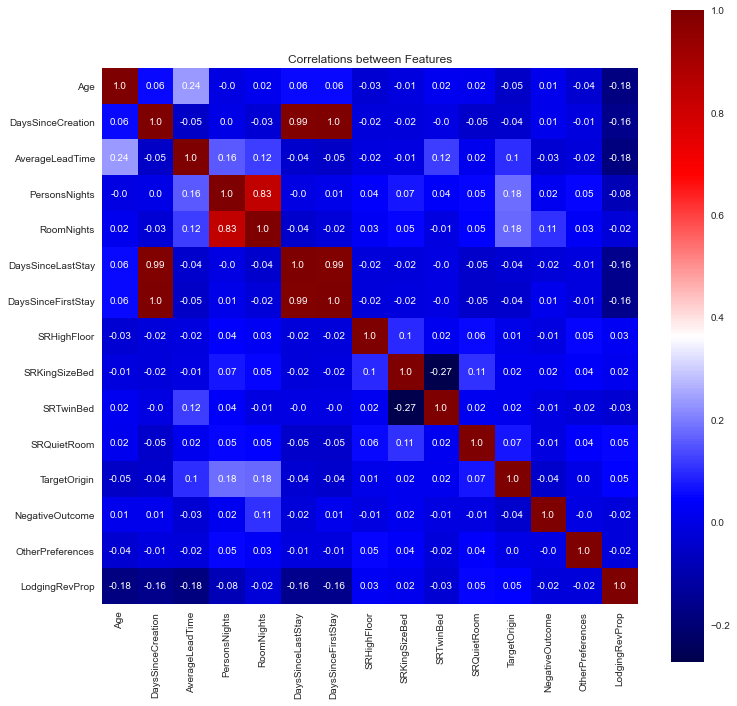

In [150]:
plt.rcParams["axes.grid"] = False
#correlation matrix
corr_matrix = hotel_features.corr().round(3)

#heatmap with matplotlib of the sorted matrix
plt.figure(figsize = (12,12))
hm = plt.imshow(corr_matrix, cmap="seismic")
plt.colorbar(hm)

xticks = plt.xticks(np.arange(len(corr_matrix.columns.to_list())), labels = corr_matrix.columns.to_list(), rotation = 90)
yticks = plt.yticks(np.arange(len(corr_matrix.columns.to_list())), labels = corr_matrix.columns.to_list())

ax = plt.gca()
for i in range(len(corr_matrix.columns.to_list())):
    for j in range(len(corr_matrix.columns.to_list())):
        text = ax.text(j, i, round(corr_matrix.iloc[i, j],2), ha="center", va="center", color="w")

plt.title("Correlations between Features")

plt.show()

In [151]:
#create new variables and drop the old ones
#it appears that for almost all customer, the first stay occured before the account was created
regr_df["DiffCreationFirstStay"] = np.where(regr_df["DaysSinceFirstStay"] >= 0, regr_df["DaysSinceFirstStay"] - regr_df["DaysSinceCreation"], -1)

#it appears that for almost all customer, the first stay occured before the account was created
regr_df["DiffFirstLastStay"] = np.where(regr_df["DaysSinceLastStay"] >= 0, regr_df["DaysSinceFirstStay"] - regr_df["DaysSinceLastStay"], -1)

regr_df = regr_df.drop(["DaysSinceLastStay", "DaysSinceFirstStay", "PersonsNights"],axis = 1).copy()

In [152]:
#checking whether these new variables are still highly correlated with DaysSinceFirstCreation
print(np.corrcoef(regr_df["DaysSinceCreation"], regr_df["DiffCreationFirstStay"]))
print(np.corrcoef(regr_df["DaysSinceCreation"], regr_df["DiffFirstLastStay"]))

[[ 1.         -0.01627852]
 [-0.01627852  1.        ]]
[[1.         0.05414216]
 [0.05414216 1.        ]]


#### Part 1.4.5: Train-Test Split
After these final pre-processing steps, the dataset will be (again) split into the features and the target variable. Afterwards, the training and testing sets will be created. 

In [3]:
#save dataframe to file
#regr_df.to_csv("Regr_Df.csv")

#open dataframe from same file
regr_df = pd.read_csv("Regr_Df.csv")

In [10]:
#separate the target variable again after the new changes
hotel_target = regr_df["TotalRevenue"].copy()
hotel_features = regr_df.drop("TotalRevenue", axis = 1).copy()

In [479]:
#splitting the datasets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(hotel_features, hotel_target, random_state = 1996, test_size = 0.15)

#### Part 1.4.6: Fill in Missing Values
As highlighted earlier, the variable Age has a small amount of missing values. After the data pre-processing, these missing values will now be filled in using a kNN Regression model. While it could be argued that it might have been better to use the "original" dataset to train this model since it contains more as well as unadjusted variables, the decision was made to fill them in now. One reason for this is that it is important to avoid data leakage; hence, the model was only trained on the train set. On another note, the kNN model was not specified or evaluated. A more thorough examination would be preferable to ensure that the impuation is optimal. In this case, I have decided to skip this step to focus on kNN another time. 

In [480]:
#generate dummys in order for the model to work
data_dummies = pd.get_dummies(X_train)

#retrieve all rows where age is missing
age_missing_train = np.isnan(data_dummies.loc[:, "Age"])

#fit the model on the dataset without the rows where age is missing and use the Age column as the label
knn_age = KNeighborsRegressor().fit(data_dummies[~age_missing_train].iloc[:,1:], data_dummies[~age_missing_train].iloc[:,0])

In [13]:
#predict the missing age values for the (adjusted) train set
pred = knn_age.predict(data_dummies[age_missing_train].iloc[:,1:])

#add the predicted values to the (adjusted) dataset
for element in range(len(pred)):
    index = data_dummies[age_missing_train].index[element]
    data_dummies.loc[index,'Age'] = pred[element]

#take the completed age column and replace the incomplete age column from the original X_train
X_train.loc[:,"Age"] = data_dummies.loc[:,'Age'].copy()

C:\Users\Computer\anaconda3\envs\TMRenv\lib\site-packages\pandas\core\indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [481]:
#repeat the previous steps to fill the missing age values in the test set (based on the model trained on the train set)
#generate dummys in order for the model to work
data_dummies_test = pd.get_dummies(X_test)

#retrieve all rows where age is missing
age_missing_test = np.isnan(data_dummies_test.loc[:, "Age"])
#predict the missing age values for the (adjusted) train set
pred_test = knn_age.predict(data_dummies_test[age_missing_test].iloc[:,1:])

#add the predicted values to the (adjusted) dataset
for element in range(len(pred_test)):
    index = data_dummies_test[age_missing_test].index[element]
    data_dummies_test.loc[index,'Age'] = pred_test[element].copy()

#take the completed age column and replace the incomplete age column from the original X_train
X_test.loc[:,"Age"] = data_dummies_test.loc[:,'Age'].copy()

C:\Users\Computer\anaconda3\envs\TMRenv\lib\site-packages\pandas\core\indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Part 2: Regression Analyses
For the purpose of predicting the total revenue per customer by using all available features, a Regression model was chosen. As regression models for large datasets are prone to overfitting, regularisation will be applied using a combination of L1 and L2 penalities (Elastic Net).
<br>
To build a good model, two steps will be taken. A pipeline will be built including scaling for the quantiative columns (except for the LodgRevProp) and dummy encoding for the categorical variables with more than two categories. 
SPecifically, Age, AverageLeadTime, DaysSinceCreation, TargetOrigin, DiffCreationFirstStay, DiffFirstLastStay, and RoomNights will be scaled using MinMaxScaler. The decision to scale them between 0 and 1 was taken to match the possible values for the boolean (dummy) variables. For the variable MarketDistribution 5 dummy variables will be created. The decision to create k - 1 rather than k dummies  for a variable with k categories is based on my statistical background. 
More details in terms of which categories the dummies represent: 
- MarketDistribution: 
    - MD1 : Direct
    - MD2 : Groups & Travel Agent
    - MD3 : Other & Travel Agent
    - MD4 : Rest
    - MD5 : Travel Agent
    - All Zero : Corporate


### Part 2.1: Grid Search
The second search is a grid search to identify the best values for alpha and the l1 ratio for the Elastic Net Algorithm. Due to limited computational capacities, the parameter grid and the number of cross validations will be limited. Given the large dataset and the emphasis on practicing, the process should still provide valuable insights. 

The initial first two grids were as follows: 
- alpha = np.logspace(-3, 3, 10), l1 ratio = [0,0.25,0.5,0.75,1]
- alpha = np.logspace(-4, 1, 5), l1 ratio = [0.5,0.6,0.7,0.8,0.9,1]

After these two steps, the final grid was narrowed down to: 
- alpha =  np.logspace(-4, 1, 10), l1 ratio = [0.5, 0.6, 0.7, 0.8, 0.9, 1] and the number of cross validations were set to 10. 
<br>
Under different circumstances, a grid with smaller steps would have been preferable

This grid search showed generally quite minimal differences between training and testing scores. Furthermore, the visualisations clearly indicated the relationship between model performance and the parameters. Specifically, there was a positive relationship between the l1 ratio and model performance indicating that a L1 penality (as for the Lasso Regression) was better. Moreover, there was a negative relationship between alpha and model performance, indicating that a lower degree of regulatisation was better. The parameters identified as optimal based on the selected paramter grid were as follows: alpha = 0.016 and l1 ratio = 1. The corresponding mean train and test scores were around 0.408. In other words, the model explained around 55% of the variance in the target variable Total Revenue. 

In [15]:
#prepare the preprocessing (scaling & dummy encoding) and the pipeline
PreProcess = make_column_transformer(
    (MinMaxScaler(), ["Age", "DaysSinceCreation", "AverageLeadTime", "RoomNights", "TargetOrigin", "LodgingRevProp", "DiffCreationFirstStay", "DiffFirstLastStay"]), 
    (OneHotEncoder(drop = "first"), ["MarketDistribution"]),
    remainder='passthrough'
    )

pipe = make_pipeline(PreProcess, ElasticNet(max_iter = 1e6))

In [160]:
#set up the parameter grid & the gird search
param_grid = {"elasticnet__alpha": np.logspace(-4, 1, 10), "elasticnet__l1_ratio": [0.5, 0.6, 0.7, 0.8, 0.9, 1]}
grid_search = GridSearchCV(pipe, param_grid, cv = 10, n_jobs = -1, return_train_score = True, verbose = True)

In [161]:
#execute the grid search
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.1min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'DaysSinceCreation',
                                                                          'AverageLeadTime',
                                                                          'RoomNights',
                                                                          'TargetOrigin',
                                                                          'LodgingRevProp',
                                                                          'DiffCreationFirstStay',
                    

In [162]:
#save the results of the grid search
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.to_csv("Grid_Results.csv")

#grid_results = pd.read_csv("Grid_Results.csv")

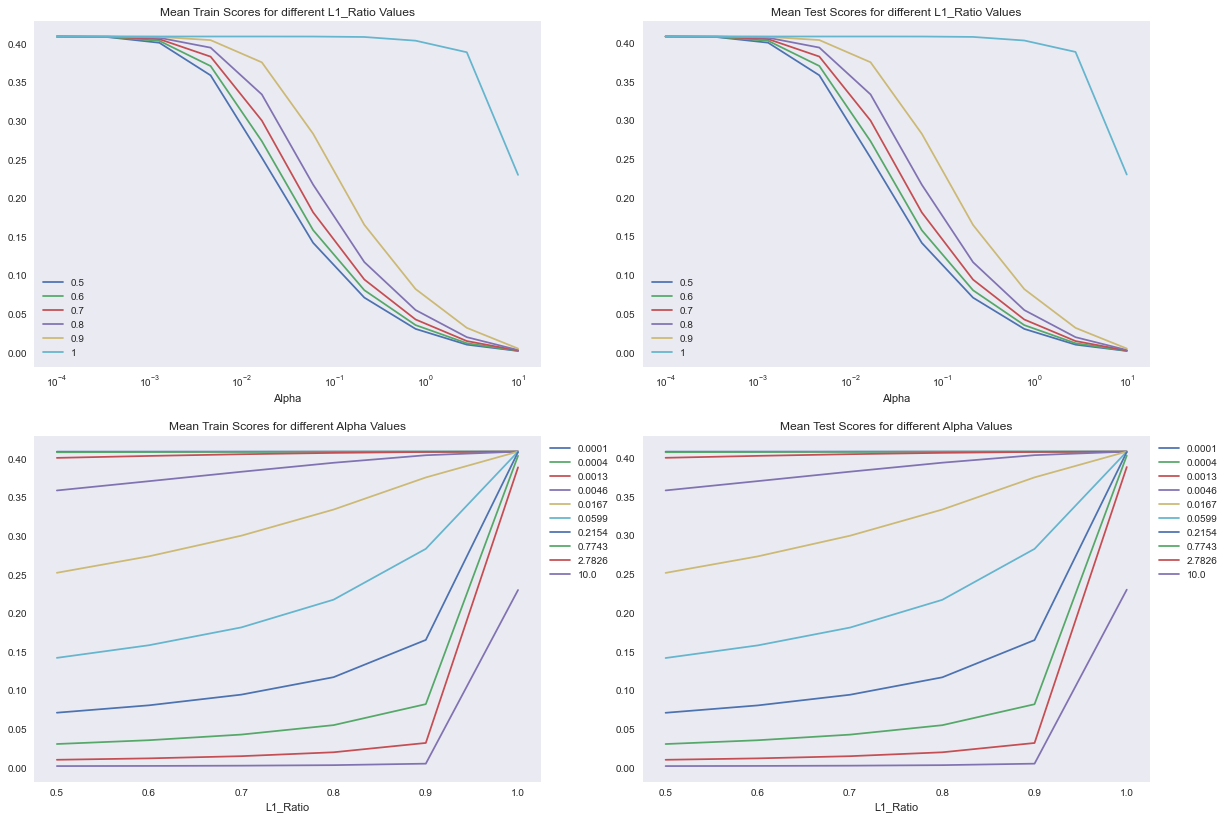

In [163]:
#plot the mean train and test scores as a function if different alpha and l1 ratio values
figure, axis = plt.subplots(2,2, figsize = (20,14))

#plot mean train scores for different l1 ratio values
for l1_ratio in param_grid["elasticnet__l1_ratio"]:
    axis[0,0].plot(grid_results["param_elasticnet__alpha"][grid_results["param_elasticnet__l1_ratio"] == l1_ratio].values, grid_results["mean_train_score"][grid_results["param_elasticnet__l1_ratio"] == l1_ratio].values, label = l1_ratio)

axis[0,0].set_xticks(param_grid["elasticnet__alpha"])
axis[0,0].set_xscale("log")
axis[0,0].set_xlabel("Alpha")
axis[0,0].set_title("Mean Train Scores for different L1_Ratio Values")
axis[0,0].legend()

#plot mean test scores for different l1 ratio values
for l1_ratio in param_grid["elasticnet__l1_ratio"]:
    axis[0,1].plot(grid_results["param_elasticnet__alpha"][grid_results["param_elasticnet__l1_ratio"] == l1_ratio].values, grid_results["mean_test_score"][grid_results["param_elasticnet__l1_ratio"] == l1_ratio].values, label = l1_ratio)

axis[0,1].set_xticks(param_grid["elasticnet__alpha"])
axis[0,1].set_xscale("log")
axis[0,1].set_xlabel("Alpha")
axis[0,1].set_title("Mean Test Scores for different L1_Ratio Values")
axis[0,1].legend()

#plot mean train scores for different alpha values
for l1_ratio in param_grid["elasticnet__alpha"]:
    axis[1,0].plot(grid_results["param_elasticnet__l1_ratio"][grid_results["param_elasticnet__alpha"] == l1_ratio].values, grid_results["mean_train_score"][grid_results["param_elasticnet__alpha"] == l1_ratio].values, label = round(l1_ratio, 4))

axis[1,0].set_xticks(param_grid["elasticnet__l1_ratio"])
axis[1,0].set_xlabel("L1_Ratio")
axis[1,0].set_title("Mean Train Scores for different Alpha Values")
axis[1,0].legend(bbox_to_anchor=(1,1), loc="upper left")

#plot mean test scores for different alpha values
for l1_ratio in param_grid["elasticnet__alpha"]:
    axis[1,1].plot(grid_results["param_elasticnet__l1_ratio"][grid_results["param_elasticnet__alpha"] == l1_ratio].values, grid_results["mean_test_score"][grid_results["param_elasticnet__alpha"] == l1_ratio].values, label = round(l1_ratio, 4))

axis[1,1].set_xticks(param_grid["elasticnet__l1_ratio"])
axis[1,1].set_xlabel("L1_Ratio")
axis[1,1].set_title("Mean Test Scores for different Alpha Values")
axis[1,1].legend(bbox_to_anchor=(1,1), loc="upper left")

plt.show()

In [164]:
#retrieve the best parameters and best score
best_params = grid_search.best_params_
best_score = round(grid_search.best_score_, 4)

print('The optimal parameter values are: \n{}'.format(best_params.values()))
print('The asscociated score is: {}\n'.format(best_score))

The optimal parameter values are: 
dict_values([0.016681005372000592, 1])
The asscociated score is: 0.4084



In [165]:
#function definition to plot the results of the gridsearch as a line plot
def plot_gridsearch(results, param, ax):
    '''
    (gridsearch results) -> line plot 
    Takes the results of a gridsearch and plots the testing and training scores as a function of the alpha parameter.
    '''
    param_name = 'param_elasticnet__{}'.format(param)

    #plot the two curves (mean training and testing scores as a function of alpha)
    ax.plot(results[param_name], results['mean_train_score'], label = 'Mean Train Score', color = 'goldenrod', lw = 2.5)
    
    ax.plot(results[param_name], results['mean_test_score'], label = 'Mean Test Score', color = 'steelblue', lw = 2.5)
    
    #fill an area of 1SD around each curve
    ax.fill_between(results[param_name].astype(np.float), results['mean_train_score'] + results['std_train_score'], results['mean_train_score'] - results['std_train_score'], alpha = 0.3, color = 'gold')
    
    ax.fill_between(results[param_name].astype(np.float), results['mean_test_score'] + results['std_test_score'],
    results['mean_test_score'] - results['std_test_score'], alpha = 0.2, color = 'lightsteelblue')
    if param == "alpha":
        ax.set_xscale('log')

In [166]:
#function definition to subset grid search results
def return_subset(grid_results, best_params, params, index):
    '''
    Takes a dataframe of grid search results, the optimal parameter values, the parameter names, and an integer. Returns a subset of the dataframe by holding all parameters constant at their optimal level except for the parameter selected by the index.
    '''
    selection = [0,1] 
    selection.remove(index)
    
    #creates the column name
    param = 'param_elasticnet__{}'.format(params[selection[0]])
    
    #amount of conditions, and the returned subset depends on the number of parameters in the grid search
    return grid_results[(grid_results[param] == best_params[param[6:]])]

In [169]:
#function definition to plot multiple grid search result plots
def plot_multiple(results, best_params, params):
    '''
    Takes the results of a gridsearch with multiple parameters, the best parameter values, and the parameter names. Creates a plot for each parameter while holding the other parameters constant (using their optimal value) using the plot_gridsearch function.
    '''
    fig, axes = plt.subplots(1,2, figsize = (20,7), sharey = True)
    
    for i, ax in enumerate(axes.ravel()):
        #select the columns for each parameter where the other parameters are held constant at their
        #optimal level and plot the relevant test and training scores
        relevant_results = return_subset(results, best_params, params, i)
        plot_gridsearch(relevant_results, params[i], ax)
        
        #adjust the plot
        ax.set_title('{}'.format(params[i]))
        
        #draw a vertical line where the optimal paramter value lies
        ax.axvline(x = best_params['elasticnet__{}'.format(params[i])], color = 'slategray', lw = 2)
        
    plt.rc('font', size = 14)
    plt.tight_layout()
    plt.show()

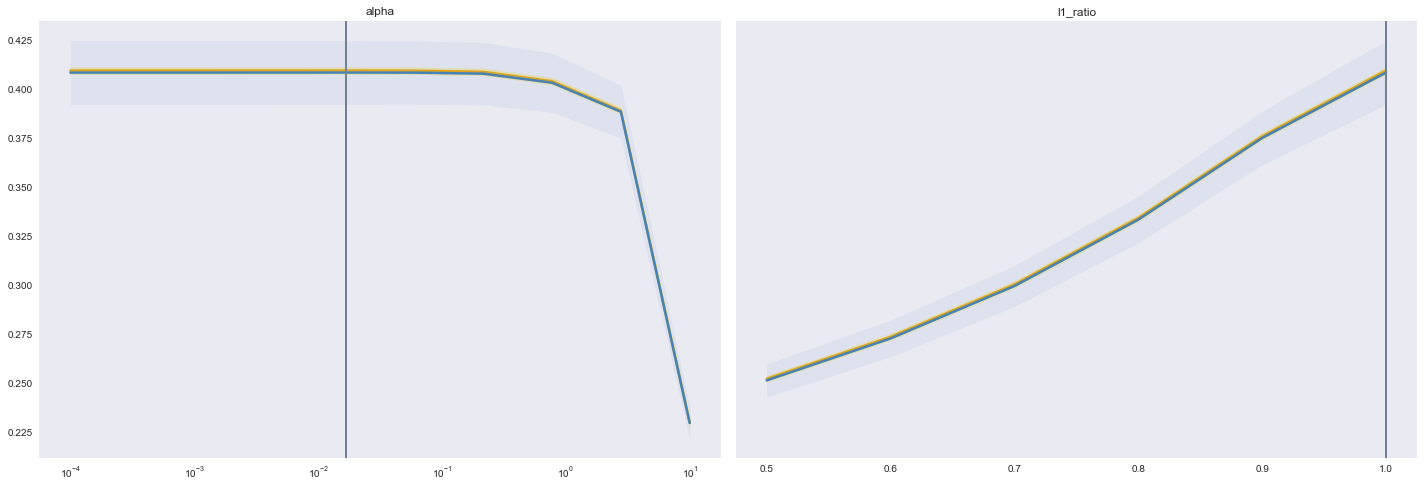

In [170]:
#plot the mean test scores for the alpha and l1_ratio values for the optimal value for the respective other parameter
plot_multiple(grid_results, best_params, ["alpha", "l1_ratio"])

### Part 2.2: Regression Diagnostics 
Having identified the optimal parameters through the GridSearch the next steps were to create the optimal model and apply several regression diagnostics. In order to return to the topic of outliers and test several assumptions, the switch to the statsmodel package was decided as sci-kit learn does not offer these same abilities. Initially, the intention was to recreate the ElasticNet model from sklearn using the optimal parameters. However, this would equally limit further analyses. Given how low the optimal alpha value was and for the purpose of applying diagnostic tools, a regular OLS regression model was fitted on the transformed and scaled data.

#### Part 2.2.1 Optimal Model
The regular OLS regression model showed an almost identical R2 score as the optimal Elastic Net model, supporting the choice that was made. While the individual predictors could be examined at this point in terms of their significance, this will be done in more depth after running diagnostics. At that later point, non-significant predictors will be excluded. 

In [482]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [485]:
#set up preprocessor (scaler & dummy encoding) outside of pipeline
ct = ColumnTransformer( [
    ("MinMax", MinMaxScaler(), ["Age", "DaysSinceCreation", "AverageLeadTime", "RoomNights", "TargetOrigin",  "DiffCreationFirstStay", "DiffFirstLastStay"]), 
    ("Dummies", OneHotEncoder(drop = "first"), ["MarketDistribution"])],
    remainder='passthrough'
    )

In [486]:
#apply preprocessing to the training set (scaler & dummy encoding)
X_train_TF = pd.DataFrame(ct.fit_transform(X_train))
X_train_TF.columns = ["Age", "DaysSinceCreation", "AverageLeadTime", "RoomNights", "TargetOrigin", "DiffCreationFirstStay", "DiffFirstLastStay", "MarketDistribution1", "MarketDistribution2", "MarketDistribution3", "MarketDistribution4", "MarketDistribution5", "Index", "SRHighFloor", "SRKingSizeBed","SRTwinBed", "SRQuietRoom", "MultipleBookings", "NegativeOutcome", "OtherPreferences", "LodgingRevProp"]

In [487]:
#apply preprocessing to the testing set (scaler & dummy encoding)
X_test_TF = pd.DataFrame(ct.transform(X_test))
X_test_TF.columns = ["Age", "DaysSinceCreation", "AverageLeadTime", "RoomNights", "TargetOrigin", "DiffCreationFirstStay", "DiffFirstLastStay", "MarketDistribution1", "MarketDistribution2", "MarketDistribution3", "MarketDistribution4", "MarketDistribution5", "Index", "SRHighFloor", "SRKingSizeBed","SRTwinBed", "SRQuietRoom", "MultipleBookings", "NegativeOutcome", "OtherPreferences", "LodgingRevProp"]

In [20]:
#combine features and target variable for the transformed and nontransformed features
Train_Set = X_train.merge(y_train, how = "left", left_on = "index", right_on = "index")
Train_Set_TF = X_train_TF.merge(y_train, how = "left", left_on = "Index", right_on = "index")

In [21]:
#fit a regular OLS regression model on the data in order to obtain regression diagnostics
results = smf.ols("TotalRevenue ~ Age + DaysSinceCreation + AverageLeadTime + RoomNights + TargetOrigin + DiffCreationFirstStay + DiffFirstLastStay + MarketDistribution1 + MarketDistribution2 + MarketDistribution3 + MarketDistribution4 + MarketDistribution5 + SRHighFloor + SRKingSizeBed + SRTwinBed + SRQuietRoom + MultipleBookings + NegativeOutcome + OtherPreferences + LodgingRevProp", data = Train_Set_TF).fit(method = "pinv")
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TotalRevenue   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     1871.
Date:                Sun, 05 Dec 2021   Prob (F-statistic):               0.00
Time:                        18:59:11   Log-Likelihood:            -3.8750e+05
No. Observations:               54026   AIC:                         7.750e+05
Df Residuals:                   54005   BIC:                         7.752e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               212.4809    146.722      1.448      0.148     -75.096     500.058
Age                     -62.1263      9.327     -6.661      0.000     -80.407     -43.845
DaysSinceCreation      -123.6824      5.050    -24.492      0.000    -133.580    -113.785
AverageLeadTime          31.2778      9.626      3.249      0.001      12.411      50.145
RoomNights             3890.6906     23.364    166.525      0.000    3844.897    3936.484
TargetOrigin             63.9354      6.592      9.698      0.000      51.014      76.856
DiffCreationFirstStay   157.8191    284.272      0.555      0.579    -399.357     714.995
DiffFirstLastStay      -689.5961     46.962    -14.684      0.000    -781.642    -597.550
MarketDistribution1     106.3692      9.611     11.068      0.000      87.532     125.207
MarketDistribution2     -10.6963      9.811     -1.090      0.276     -29.926       8.534
MarketDistribution3      60.3251      9.222      6.541      0.000      42.250      78.401
MarketDistribution4     -58.4130     11.265     -5.185      0.000     -80.492     -36.334
MarketDistribution5    -106.1251      9.710    -10.929      0.000    -125.157     -87.093
SRHighFloor               3.4564      6.657      0.519      0.604      -9.592      16.505
SRKingSizeBed           -25.8666      3.263     -7.927      0.000     -32.262     -19.471
SRTwinBed                34.4452      4.233      8.138      0.000      26.149      42.741
SRQuietRoom              34.0640      4.992      6.824      0.000      24.280      43.848
MultipleBookings        213.0693     10.959     19.442      0.000     191.589     234.550
NegativeOutcome        -209.8894     31.567     -6.649      0.000    -271.761    -148.018
OtherPreferences          7.3729      9.866      0.747      0.455     -11.965      26.711
LodgingRevProp          -90.7178     10.307     -8.802      0.000    -110.919     -70.516
==============================================================================
Omnibus:                    46688.129   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1969830.468
Skew:                           4.018   Prob(JB):                         0.00
Kurtosis:                      31.469   Cond. No.                         417.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### PART 2.2.2: Outlier Diagnostics
After fitting the OLS model, the following outlier diagnostics were obtained for each observation/customer: studentized residual (called resid_student), leverage (called leverage), Cook's D (called cooks) and DFFITS (called dffits). Next, these diagnostics will be examined individually and in conjunction, to determine whether there are customers that should be excluded to obtain a better model fit. 

In [22]:
#obtain regression diagnostics for the regular model
influence = results.get_influence()

In [23]:
#retrieve the studentized residuals
resid_student = influence.resid_studentized_external

In [24]:
#retrieve cook's
(cooks, p) = influence.cooks_distance

#retrieve the dffits values
(dffits, p) = influence.dffits

#retrieve the leverage values
leverage = influence.hat_matrix_diag

In [25]:
#combine diagnostics with dataframe
Train_Set_Diag = pd.concat([pd.Series(cooks, name = "cooks"), pd.Series(dffits, name = "dffits"), pd.Series(leverage, name = "leverage"), pd.Series(resid_student, name = "resid_student")], axis = 1)

Train_Set_Diag = pd.concat([Train_Set, Train_Set_Diag], axis = 1)

In [26]:
#save and import data
Train_Set_Diag.to_csv("Train_Set_Diag.csv")
#Train_Set_Diag = pd.read_csv("Train_Set_Diag.csv")
Train_Set_Diag.head()

,index,Age,DaysSinceCreation,AverageLeadTime,RoomNights,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,TargetOrigin,MultipleBookings,NegativeOutcome,OtherPreferences,MarketDistribution,LodgingRevProp,DiffCreationFirstStay,DiffFirstLastStay,TotalRevenue,cooks,dffits,leverage,resid_student
0,17030,58.0,781,124,4,0,1,0,1,342.155369,0,0,0,Other & Travel Agent,0.934902,4,0,599.10,8.163546e-09,0.000414,0.000307,0.023631
1,38866,42.2,426,286,4,0,0,0,1,291.510158,0,0,0,Other & Travel Agent,0.784832,4,0,590.19,1.628340e-06,-0.005848,0.000488,-0.264777
2,24477,22.0,634,91,4,1,1,0,0,375.188045,0,0,0,Other & Travel Agent,0.882353,4,0,1428.00,1.603396e-04,0.058030,0.000506,2.579751
3,38508,43.0,431,136,1,0,0,0,0,342.155369,0,0,1,Other & Travel Agent,0.977827,1,0,90.20,9.000158e-06,-0.013748,0.001120,-0.410573
4,6415,49.0,940,72,3,0,0,0,0,386.247649,0,0,0,Other & Travel Agent,0.872854,3,0,330.33,7.812826e-07,-0.004051,0.000115,-0.377521


##### Part 2.2.2.1: Studentized Residuals
The general boundaries for examining possibly problematic obsrevations based on the values of the studentized residual, are 2, 2.5 and 3. Quite a number of observations were above this boundary, with much fewer below. Considering only the bottom 10 observations, the general pattern that stands out is that these customers generally have a higher RoomNights, have mostly checked in more than once, frequently show a very high proportion of revenue from lodging (or zero), and either a rather high or rather low total revenue. <br>
In terms of the top 10 observations, these customers are much more average in their features while showing an extremely high total revenue. <br>
It appears that customers with extremely low but mostly with extremely high total revenue values have the highest residual as a different total revenue is predicted based on the features. 
It likely would have been good to initially divide the lodging revenue by the roomnights to see if there are any extreme outliers (concerning the revenue by nights/rooms) which might warrant exclusion. 

In [27]:
#examine studentized residuals 
print(Train_Set_Diag["resid_student"].describe(), "\n")

print("Residuals Over 3 \n", (Train_Set_Diag["resid_student"] > 3).value_counts(), "\n")
print("Residuals Below -3 \n", (Train_Set_Diag["resid_student"] < -3).value_counts())

count    54026.000000
mean         0.000042
std          1.000380
min         -7.132194
25%         -0.440271
50%         -0.185340
75%          0.118635
max         14.576168
Name: resid_student, dtype: float64 

Residuals Over 3 
 False    52917
True      1109
Name: resid_student, dtype: int64 

Residuals Below -3 
 False    53995
True        31
Name: resid_student, dtype: int64


In [28]:
#top negative studentized residuals
Train_Set_Diag.sort_values(by = "resid_student").iloc[:10,:]

,index,Age,DaysSinceCreation,AverageLeadTime,RoomNights,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,TargetOrigin,MultipleBookings,NegativeOutcome,OtherPreferences,MarketDistribution,LodgingRevProp,DiffCreationFirstStay,DiffFirstLastStay,TotalRevenue,cooks,dffits,leverage,resid_student
51246,37434,49.0,446,14,24,0,0,0,0,366.330100,1,0,0,Travel Agent,0.947644,4,387,955.00,0.011501,-0.491666,0.004730,-7.132194
22588,10004,11.0,885,1,13,0,0,0,0,389.831097,0,0,0,Direct,0.000000,13,0,52.00,0.003179,-0.258468,0.001756,-6.163419
17183,49465,58.0,226,50,12,0,1,0,0,291.510158,1,0,0,Rest,0.000000,3,112,0.00,0.003525,-0.272161,0.002221,-5.768235
16140,17874,46.0,767,17,12,0,0,0,0,305.540097,1,0,0,Other & Travel Agent,0.959134,1,3,146.82,0.002580,-0.232850,0.001757,-5.550881
41334,54776,51.0,145,52,26,0,1,0,0,291.510158,1,1,0,Corporate,0.885873,2,134,1805.00,0.017768,-0.611009,0.012181,-5.502369
27449,49768,80.0,222,66,15,0,1,0,0,291.510158,1,0,0,Rest,0.000000,4,9,696.00,0.003568,-0.273776,0.002921,-5.058618
40504,52052,48.0,190,58,23,0,1,0,0,291.510158,1,1,0,Corporate,0.874356,1,179,1552.00,0.012773,-0.518013,0.011161,-4.875782
9798,61652,43.0,44,4,26,0,0,0,0,305.540097,1,0,0,Corporate,0.915148,13,21,2386.50,0.005314,-0.334107,0.005082,-4.674810
27531,41304,28.0,381,8,28,0,0,0,0,366.330100,1,0,0,Rest,0.897230,4,70,2584.40,0.005238,-0.331708,0.005138,-4.615727
46646,51959,52.0,191,37,25,0,1,0,0,291.510158,1,1,0,Corporate,0.914216,1,164,2040.00,0.010033,-0.459078,0.011726,-4.214588


In [30]:
#top positive studentized residuals
Train_Set_Diag.sort_values(by = "resid_student").iloc[-10:,:]

,index,Age,DaysSinceCreation,AverageLeadTime,RoomNights,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,TargetOrigin,MultipleBookings,NegativeOutcome,OtherPreferences,MarketDistribution,LodgingRevProp,DiffCreationFirstStay,DiffFirstLastStay,TotalRevenue,cooks,dffits,leverage,resid_student
48584,12175,47.0,853,186,4,0,0,0,0,379.428879,0,0,0,Other & Travel Agent,0.873950,4,0,4581.5,0.001082,0.150985,0.000143,12.633307
49067,58113,35.0,96,20,6,0,1,0,0,422.990345,0,0,0,Groups & Travel Agent,0.976193,6,0,4935.5,0.003404,0.267762,0.000431,12.901124
40489,35073,37.0,477,49,6,0,1,0,0,420.000529,0,0,0,Other & Travel Agent,0.919865,6,0,5029.0,0.001233,0.161141,0.000151,13.094047
44714,62580,66.0,24,5,6,0,1,0,0,342.155369,0,0,0,Other & Travel Agent,0.861676,6,0,5161.8,0.002301,0.220196,0.000267,13.485690
15948,32286,40.0,520,60,4,0,0,0,0,342.832093,0,0,0,Other & Travel Agent,0.863686,4,0,5043.5,0.000898,0.137548,0.000096,14.027059
21325,55627,52.0,131,128,4,0,0,0,0,366.330100,0,0,0,Direct,0.646261,4,0,5162.0,0.002260,0.218244,0.000241,14.045094
7016,48503,76.0,242,57,7,0,0,0,0,389.831097,1,0,0,Direct,0.766982,4,7,5815.0,0.013502,0.533475,0.001399,14.253904
18758,37524,43.0,445,130,5,0,0,0,0,378.350737,0,0,0,Travel Agent,0.748448,5,0,5156.0,0.001580,0.182511,0.000161,14.370888
4725,53234,31.0,172,150,3,0,0,0,0,291.510158,0,0,0,Direct,0.893729,3,0,5119.0,0.002870,0.245992,0.000289,14.468321
25941,27078,49.0,596,80,4,0,0,0,0,342.832093,0,0,0,Direct,0.743373,3,0,5259.0,0.001824,0.196074,0.000181,14.576168


##### Part 2.2.2.2 Leverage
For leverage, a typical boundary to warrant further examination is defined as: $(2 * nr\_predictors + 2)/nr\_observations$. Based on this boundary, the high amount of 4676 observations were marked as possibly problematic. In terms of customers with high leverage, the main pattern was a lower value on the TargetOrigin variable and having checked in more than once.
<br> 
When examining leverage in conjunction with the residuals, it appears that variables either score high on one or the other diagnostic, but not necessarily on both. Specifically, "only" 166 customers score above both boundaries. Additionally, from the graphs it appeared that extremely high leverage values were less common that extremely high residuals, although the graphs do not take the boundaries into account. 

In [31]:
#examine leverage 
lev_bound = (2 * len(X_train_TF.columns) + 2)/len(Train_Set_Diag) #boundary for examination
print("Boundary: ", lev_bound, "\n")

print(Train_Set_Diag["leverage"].describe(), "\n")

print("Residuals Above Boundary \n", (Train_Set_Diag["leverage"] > lev_bound).value_counts(), "\n")

Boundary:  0.0008144226853737089 

count    54026.000000
mean         0.000389
std          0.001838
min          0.000068
25%          0.000173
50%          0.000248
75%          0.000356
max          0.217105
Name: leverage, dtype: float64 

Residuals Above Boundary 
 False    50134
True      3892
Name: leverage, dtype: int64 



In [32]:
#observations with the largest leverage
Train_Set_Diag.sort_values(by = "leverage").iloc[-10:,:]

,index,Age,DaysSinceCreation,AverageLeadTime,RoomNights,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,TargetOrigin,MultipleBookings,NegativeOutcome,OtherPreferences,MarketDistribution,LodgingRevProp,DiffCreationFirstStay,DiffFirstLastStay,TotalRevenue,cooks,dffits,leverage,resid_student
35864,4605,38.0,972,5,27,0,1,0,0,291.510158,1,1,0,Corporate,0.887363,1,905,2548.00,2.492841e-03,-0.228804,0.018330,-1.674415
15061,500,55.0,1067,0,2,0,1,0,0,291.510158,1,0,0,Direct,0.802139,1,1044,187.00,1.344324e-03,0.168021,0.018777,1.214605
21772,603,51.0,1059,35,2,0,0,1,0,291.510158,0,0,0,Travel Agent,0.654545,-290,0,577.50,3.761508e-03,0.281058,0.034711,1.482137
30383,23183,44.0,654,33,7,0,1,0,0,291.510158,1,0,0,Rest,0.860060,419,767,614.55,3.083236e-07,-0.002545,0.073369,-0.009043
38641,40985,48.0,389,61,24,0,1,0,0,400.621156,1,0,0,Other & Travel Agent,0.855214,436,791,3383.95,2.325245e-03,0.220975,0.075170,0.775087
48745,19388,41.6,730,9,3,0,1,0,0,291.510158,1,0,0,Rest,0.000000,456,454,39.00,4.409072e-03,-0.304287,0.084112,-1.004098
3795,62083,63.0,36,45,7,0,0,0,0,291.510158,1,0,0,Direct,0.774862,583,582,899.45,1.134906e-03,-0.154378,0.134646,-0.391370
33501,41388,41.0,379,18,3,0,1,0,0,291.510158,1,0,0,Corporate,0.615909,691,690,440.00,4.790373e-03,0.317170,0.191771,0.651129
4410,1386,30.0,1032,18,1,0,0,1,0,291.510158,0,1,0,Travel Agent,0.791045,-689,0,67.00,1.640442e-02,0.586937,0.194069,1.196087
50679,1320,44.0,1033,14,3,0,1,0,0,291.510158,1,0,0,Travel Agent,0.730337,-727,194,178.00,5.066190e-04,-0.103145,0.217105,-0.195868


In [33]:
Train_Set_Diag["resid_student_sqrd"] = Train_Set_Diag["resid_student"] ** 2

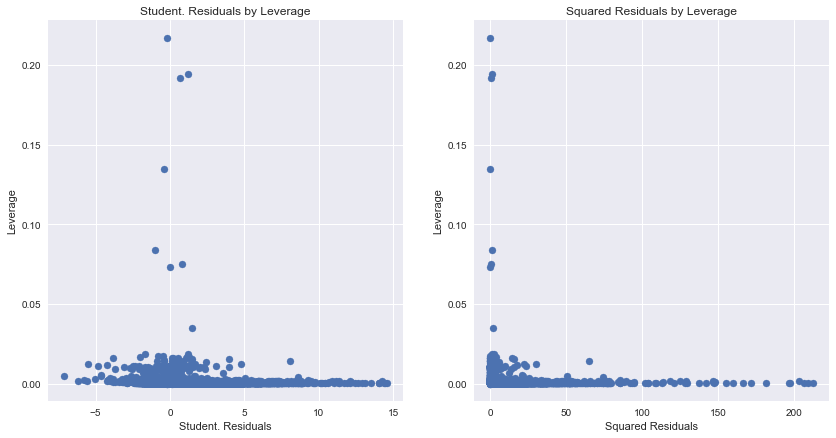

In [34]:
#plot Leverage v.s (squared) Studentized Residuals
figure, axis = plt.subplots(1,2, figsize = (14,7))

axis[0].scatter(Train_Set_Diag["resid_student"], Train_Set_Diag["leverage"])
axis[0].set_xlabel("Student. Residuals")
axis[0].set_ylabel("Leverage")
axis[0].set_title("Student. Residuals by Leverage")

axis[1].scatter(Train_Set_Diag["resid_student_sqrd"], Train_Set_Diag["leverage"])
axis[1].set_xlabel("Squared Residuals")
axis[1].set_ylabel("Leverage")
axis[1].set_title("Squared Residuals by Leverage")

plt.show()

In [35]:
#identify data points with both a large residual and high leverage
Train_Set_Diag[(abs(Train_Set_Diag["resid_student"]) > 3) & (Train_Set_Diag["leverage"] > lev_bound)]

,index,Age,DaysSinceCreation,AverageLeadTime,RoomNights,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,TargetOrigin,MultipleBookings,NegativeOutcome,OtherPreferences,MarketDistribution,LodgingRevProp,DiffCreationFirstStay,DiffFirstLastStay,TotalRevenue,cooks,dffits,leverage,resid_student,resid_student_sqrd
235,46297,32.0,274,58,4,1,0,1,1,366.330100,0,0,1,Other & Travel Agent,0.902431,4,0,1721.85,0.000730,0.123813,0.001590,3.102810,9.627430
1088,5524,79.0,956,3,6,0,0,1,0,379.428879,0,0,1,Other & Travel Agent,0.787554,6,0,2796.00,0.002403,0.224716,0.001376,6.052718,36.635393
1152,28275,69.0,579,223,15,0,0,1,0,435.986491,0,0,0,Other & Travel Agent,0.961153,15,0,1222.75,0.000528,-0.105317,0.001160,-3.089778,9.546726
1659,52668,19.0,180,267,3,1,1,0,0,379.428879,0,0,0,Direct,0.498069,3,0,1864.80,0.000688,0.120258,0.000927,3.947941,15.586239
1794,37451,75.0,446,4,5,0,0,0,0,305.540097,1,0,0,Direct,0.950295,5,304,2374.00,0.002281,0.218908,0.001887,5.034637,25.347574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52695,8210,56.0,914,9,5,0,1,0,0,291.510158,1,0,0,Corporate,0.331839,1,865,1784.00,0.013562,0.533772,0.012477,4.748598,22.549187
53031,50299,57.0,212,46,6,0,1,0,0,291.510158,1,0,0,Rest,0.000000,3,56,30.00,0.000908,-0.138101,0.001920,-3.148403,9.912440
53077,55506,47.0,133,3,8,0,0,0,1,389.831097,1,0,0,Rest,0.821200,1,1,2500.00,0.001098,0.151882,0.001778,3.598352,12.948134
53595,54491,38.0,151,119,6,0,0,0,0,366.330100,0,0,1,Direct,0.815419,6,0,2023.50,0.000556,0.108027,0.001144,3.191906,10.188266


##### Part 2.2.2.3 Cook's Distance & DFFIT
As these two diagnostics essentially measure the same thing, they were examined together. The scatterplot shows this relationship. 
<br> 
Showing the same pattern as before, a relatively large amount of observations fall above the boundary. The boundary was defined as: $4/nr\_observations$. In terms of the top observations, the low Target Origin, and having checked in more than once all stand out. Unsurprisingly, these customers also showed a large total revenue. 
<br>
Examining the DFFIT, the same customers stand out. This time a boundary of $\pm 2*\sqrt(nr\_predictors/nr\_observations)$ was used. 

In [39]:
#examine Cook's distance
cook_bound = 4/len(X_train_TF) #boundary for examination
print("Boundary: ", cook_bound, "\n")

print(Train_Set_Diag["cooks"].describe(), "\n")
print("Cook's Distance Above Boundary \n", (Train_Set_Diag["cooks"] > cook_bound).value_counts(), "\n")

Boundary:  7.403842594306445e-05 

count    5.402600e+04
mean     2.710926e-05
std      3.332452e-04
min      1.398358e-14
25%      3.027689e-07
50%      1.361313e-06
75%      5.134905e-06
max      4.452779e-02
Name: cooks, dtype: float64 

Cook's Distance Above Boundary 
 False    51582
True      2444
Name: cooks, dtype: int64 



In [38]:
#observations with the largest Cook's distance
Train_Set_Diag.sort_values(by = "cooks").iloc[-10:,:]

,index,Age,DaysSinceCreation,AverageLeadTime,RoomNights,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,TargetOrigin,MultipleBookings,NegativeOutcome,OtherPreferences,MarketDistribution,LodgingRevProp,DiffCreationFirstStay,DiffFirstLastStay,TotalRevenue,cooks,dffits,leverage,resid_student,resid_student_sqrd
51246,37434,49.0,446,14,24,0,0,0,0,366.330100,1,0,0,Travel Agent,0.947644,4,387,955.00,0.011501,-0.491666,0.004730,-7.132194,50.868197
20638,364,56.0,1075,7,10,0,1,0,0,291.510158,1,0,0,Corporate,0.370629,2,964,2145.00,0.011776,0.497354,0.015474,3.967140,15.738203
22191,54463,63.0,152,6,4,0,1,0,0,489.026814,1,0,0,Rest,0.921081,3,3,4568.00,0.012348,0.509898,0.001772,12.100816,146.429753
40504,52052,48.0,190,58,23,0,1,0,0,291.510158,1,1,0,Corporate,0.874356,1,179,1552.00,0.012773,-0.518013,0.011161,-4.875782,23.773247
7016,48503,76.0,242,57,7,0,0,0,0,389.831097,1,0,0,Direct,0.766982,4,7,5815.00,0.013502,0.533475,0.001399,14.253904,203.173789
52695,8210,56.0,914,9,5,0,1,0,0,291.510158,1,0,0,Corporate,0.331839,1,865,1784.00,0.013562,0.533772,0.012477,4.748598,22.549187
4208,26165,50.0,609,6,21,0,0,0,0,291.510158,1,0,0,Corporate,0.809205,7,7,5823.00,0.013811,0.538913,0.003882,8.633046,74.529488
4410,1386,30.0,1032,18,1,0,0,1,0,291.510158,0,1,0,Travel Agent,0.791045,-689,0,67.00,0.016404,0.586937,0.194069,1.196087,1.430624
41334,54776,51.0,145,52,26,0,1,0,0,291.510158,1,1,0,Corporate,0.885873,2,134,1805.00,0.017768,-0.611009,0.012181,-5.502369,30.276061
34484,16449,51.0,791,4,16,0,1,0,0,366.330100,1,1,0,Rest,0.900568,5,753,4144.05,0.044528,0.967570,0.014189,8.064886,65.042383


In [40]:
#examine DFFIT
dffit_bound = 2 * np.sqrt(len(X_train_TF.columns)/len(X_train_TF)) #boundary for examination
print("Boundary: ", dffit_bound, "\n")

print(Train_Set_Diag["dffits"].describe(), "\n")

print("Residuals Above Boundary \n", (Train_Set_Diag["dffits"] > dffit_bound).value_counts(), "\n")
print("Residuals Below Boundary \n", (Train_Set_Diag["dffits"] < -dffit_bound).value_counts())

Boundary:  0.03943104037182323 

count    54026.000000
mean         0.000086
std          0.023867
min         -0.611009
25%         -0.006971
50%         -0.002793
75%          0.001931
max          0.967570
Name: dffits, dtype: float64 

Residuals Above Boundary 
 False    52122
True      1904
Name: dffits, dtype: int64 

Residuals Below Boundary 
 False    53486
True       540
Name: dffits, dtype: int64


In [41]:
#top negative DFFIT
Train_Set_Diag.sort_values(by = "dffits").iloc[:10,:]

,index,Age,DaysSinceCreation,AverageLeadTime,RoomNights,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,TargetOrigin,MultipleBookings,NegativeOutcome,OtherPreferences,MarketDistribution,LodgingRevProp,DiffCreationFirstStay,DiffFirstLastStay,TotalRevenue,cooks,dffits,leverage,resid_student,resid_student_sqrd
41334,54776,51.0,145,52,26,0,1,0,0,291.510158,1,1,0,Corporate,0.885873,2,134,1805.0,0.017768,-0.611009,0.012181,-5.502369,30.276061
40504,52052,48.0,190,58,23,0,1,0,0,291.510158,1,1,0,Corporate,0.874356,1,179,1552.0,0.012773,-0.518013,0.011161,-4.875782,23.773247
51246,37434,49.0,446,14,24,0,0,0,0,366.330100,1,0,0,Travel Agent,0.947644,4,387,955.0,0.011501,-0.491666,0.004730,-7.132194,50.868197
29471,10349,48.0,880,6,26,0,1,0,0,291.510158,1,1,0,Corporate,0.888889,1,818,1800.0,0.011441,-0.490232,0.016235,-3.816075,14.562426
46646,51959,52.0,191,37,25,0,1,0,0,291.510158,1,1,0,Corporate,0.914216,1,164,2040.0,0.010033,-0.459078,0.011726,-4.214588,17.762753
29071,16914,55.0,783,26,11,0,0,1,0,291.510158,1,0,0,Direct,0.648649,1,732,203.5,0.005998,-0.354945,0.009012,-3.722038,13.853570
9798,61652,43.0,44,4,26,0,0,0,0,305.540097,1,0,0,Corporate,0.915148,13,21,2386.5,0.005314,-0.334107,0.005082,-4.674810,21.853847
27531,41304,28.0,381,8,28,0,0,0,0,366.330100,1,0,0,Rest,0.897230,4,70,2584.4,0.005238,-0.331708,0.005138,-4.615727,21.304935
2255,13624,57.8,832,4,9,0,1,1,0,291.510158,1,1,0,Rest,0.000000,2,394,5.0,0.004696,-0.314059,0.010377,-3.067018,9.406601
48745,19388,41.6,730,9,3,0,1,0,0,291.510158,1,0,0,Rest,0.000000,456,454,39.0,0.004409,-0.304287,0.084112,-1.004098,1.008214


In [42]:
#top positive DFFIT
Train_Set_Diag.sort_values(by = "dffits").iloc[-10:,:]

,index,Age,DaysSinceCreation,AverageLeadTime,RoomNights,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,TargetOrigin,MultipleBookings,NegativeOutcome,OtherPreferences,MarketDistribution,LodgingRevProp,DiffCreationFirstStay,DiffFirstLastStay,TotalRevenue,cooks,dffits,leverage,resid_student,resid_student_sqrd
35850,35263,82.0,476,26,15,0,0,0,0,291.510158,1,0,0,Direct,0.792454,6,20,5279.85,0.008899,0.432627,0.002183,9.249216,85.547999
22983,48558,38.0,241,170,5,0,0,0,0,389.831097,1,0,0,Other & Travel Agent,0.784128,1,5,4864.00,0.009108,0.437924,0.001296,12.157880,147.814054
29669,54464,22.0,152,6,4,0,0,1,0,489.026814,1,0,0,Rest,0.844393,3,3,4280.00,0.010425,0.468402,0.001848,10.885106,118.485538
20638,364,56.0,1075,7,10,0,1,0,0,291.510158,1,0,0,Corporate,0.370629,2,964,2145.00,0.011776,0.497354,0.015474,3.967140,15.738203
22191,54463,63.0,152,6,4,0,1,0,0,489.026814,1,0,0,Rest,0.921081,3,3,4568.00,0.012348,0.509898,0.001772,12.100816,146.429753
7016,48503,76.0,242,57,7,0,0,0,0,389.831097,1,0,0,Direct,0.766982,4,7,5815.00,0.013502,0.533475,0.001399,14.253904,203.173789
52695,8210,56.0,914,9,5,0,1,0,0,291.510158,1,0,0,Corporate,0.331839,1,865,1784.00,0.013562,0.533772,0.012477,4.748598,22.549187
4208,26165,50.0,609,6,21,0,0,0,0,291.510158,1,0,0,Corporate,0.809205,7,7,5823.00,0.013811,0.538913,0.003882,8.633046,74.529488
4410,1386,30.0,1032,18,1,0,0,1,0,291.510158,0,1,0,Travel Agent,0.791045,-689,0,67.00,0.016404,0.586937,0.194069,1.196087,1.430624
34484,16449,51.0,791,4,16,0,1,0,0,366.330100,1,1,0,Rest,0.900568,5,753,4144.05,0.044528,0.967570,0.014189,8.064886,65.042383


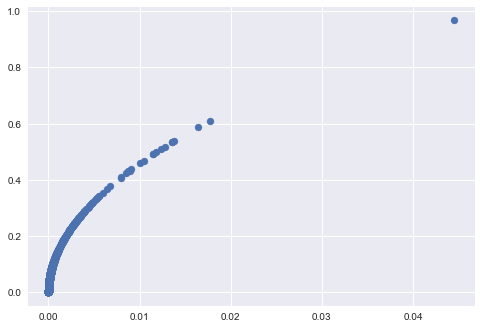

In [43]:
plt.scatter(Train_Set_Diag["cooks"], abs(Train_Set_Diag["dffits"]))

##### Part 2.2.2.5 Combined Diagnostics
After examining the four diagnostics, datapoints scoring above (or below) the four boundaries will be identified. This returns 166 customers with a main similarity being an extremely high or low total revenue score. 
For some of these customers the dfbeta values were briefly examined. These values were relatively low compared to the actual regression coefficients, but the outliers likely have a compound effect on the model. 

In [44]:
#identify data points that score high on all four measures
Train_Set_Diag[
    (abs(Train_Set_Diag["resid_student"]) > 3) & 
    (Train_Set_Diag["leverage"] > lev_bound) &
    (abs(Train_Set_Diag["dffits"]) > dffit_bound) & 
    (Train_Set_Diag["cooks"] > cook_bound)
]

,index,Age,DaysSinceCreation,AverageLeadTime,RoomNights,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,TargetOrigin,MultipleBookings,NegativeOutcome,OtherPreferences,MarketDistribution,LodgingRevProp,DiffCreationFirstStay,DiffFirstLastStay,TotalRevenue,cooks,dffits,leverage,resid_student,resid_student_sqrd
235,46297,32.0,274,58,4,1,0,1,1,366.330100,0,0,1,Other & Travel Agent,0.902431,4,0,1721.85,0.000730,0.123813,0.001590,3.102810,9.627430
1088,5524,79.0,956,3,6,0,0,1,0,379.428879,0,0,1,Other & Travel Agent,0.787554,6,0,2796.00,0.002403,0.224716,0.001376,6.052718,36.635393
1152,28275,69.0,579,223,15,0,0,1,0,435.986491,0,0,0,Other & Travel Agent,0.961153,15,0,1222.75,0.000528,-0.105317,0.001160,-3.089778,9.546726
1659,52668,19.0,180,267,3,1,1,0,0,379.428879,0,0,0,Direct,0.498069,3,0,1864.80,0.000688,0.120258,0.000927,3.947941,15.586239
1794,37451,75.0,446,4,5,0,0,0,0,305.540097,1,0,0,Direct,0.950295,5,304,2374.00,0.002281,0.218908,0.001887,5.034637,25.347574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52695,8210,56.0,914,9,5,0,1,0,0,291.510158,1,0,0,Corporate,0.331839,1,865,1784.00,0.013562,0.533772,0.012477,4.748598,22.549187
53031,50299,57.0,212,46,6,0,1,0,0,291.510158,1,0,0,Rest,0.000000,3,56,30.00,0.000908,-0.138101,0.001920,-3.148403,9.912440
53077,55506,47.0,133,3,8,0,0,0,1,389.831097,1,0,0,Rest,0.821200,1,1,2500.00,0.001098,0.151882,0.001778,3.598352,12.948134
53595,54491,38.0,151,119,6,0,0,0,0,366.330100,0,0,1,Direct,0.815419,6,0,2023.50,0.000556,0.108027,0.001144,3.191906,10.188266


In [45]:
#retrieve the dfbetas values
dfbetas = influence.dfbetas

dfbetas_df = pd.DataFrame(dfbetas)
dfbetas_df.columns = ["Intercept"] + X_train_TF.drop("Index", axis = 1).columns.tolist()

dfbetas_df.head()

,Intercept,Age,DaysSinceCreation,AverageLeadTime,RoomNights,TargetOrigin,DiffCreationFirstStay,DiffFirstLastStay,MarketDistribution1,MarketDistribution2,MarketDistribution3,MarketDistribution4,MarketDistribution5,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,MultipleBookings,NegativeOutcome,OtherPreferences,LodgingRevProp
0,-0.000013,0.000061,0.000116,0.000048,0.000052,-0.000090,0.000003,-0.000013,-0.000003,-0.000006,-0.000008,0.000014,-0.000002,-0.000046,0.000100,-0.000015,0.000318,-0.000022,-0.000006,-0.000024,0.000110
1,-0.000080,0.001110,0.000139,-0.002934,-0.000600,0.002741,0.000008,-0.000005,0.000027,0.000159,-0.000330,-0.000028,0.000209,0.000362,0.001845,0.001407,-0.003666,0.000155,0.000015,0.000273,0.000207
2,-0.000071,-0.017946,0.006403,0.005368,0.004430,0.000182,0.000271,-0.001084,-0.001962,0.000313,-0.000784,-0.000044,-0.000638,0.050155,0.008823,-0.003091,-0.006574,-0.000959,-0.000088,-0.004846,0.002948
3,0.000101,-0.000102,0.000231,-0.002129,0.002297,0.001050,0.000010,-0.000341,0.000170,-0.000211,-0.001025,-0.000313,-0.000168,0.000933,0.002671,0.001508,0.001269,-0.000165,-0.000274,-0.012811,-0.002245
4,0.000108,-0.000464,-0.002204,-0.000169,0.000078,-0.000672,-0.000021,0.000057,-0.000020,-0.000022,-0.000687,-0.000053,0.000133,0.000265,0.002042,0.001305,0.000702,-0.000113,-0.000061,0.000081,-0.000687


In [46]:
#show the dfbetas for data points that show high values on all four (other) diagnostic measures
dfbetas_df.iloc[Train_Set_Diag[(abs(Train_Set_Diag["resid_student"]) > 5) & (Train_Set_Diag["leverage"] > lev_bound * 5) & (abs(Train_Set_Diag["dffits"]) > dffit_bound) & (Train_Set_Diag["cooks"] > cook_bound)].index,]

,Intercept,Age,DaysSinceCreation,AverageLeadTime,RoomNights,TargetOrigin,DiffCreationFirstStay,DiffFirstLastStay,MarketDistribution1,MarketDistribution2,MarketDistribution3,MarketDistribution4,MarketDistribution5,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,MultipleBookings,NegativeOutcome,OtherPreferences,LodgingRevProp
34484,0.035721,0.012476,-0.003369,-0.007655,0.105633,0.019618,-0.051937,0.530501,0.151191,0.161501,0.161978,0.221609,0.158104,-0.006618,0.024983,0.008387,-0.010790,-0.196762,0.580087,-0.008000,0.065454
41334,-0.028481,-0.001347,0.018084,0.013684,-0.271166,0.062317,0.025885,0.152238,0.084041,0.079270,0.089336,0.085581,0.085522,0.007446,-0.021502,-0.006771,0.014122,-0.068488,-0.480843,0.008718,-0.016453
51246,-0.103888,-0.007203,0.020932,0.058240,-0.328089,0.040696,0.111539,-0.249201,-0.042022,-0.051887,-0.048357,-0.022471,-0.071406,0.007214,0.033556,0.009373,0.011313,-0.017815,0.127785,0.012425,-0.037603


##### Part 2.2.2.6 Excluding Outliers
These 166 customers were subsequently excluded and the model was refitted. Aside from an improved R2 of 0.42, several regression coefficients changed by more than a small amount: DiffCreationFirstStay was reduced by around a third, the MarketDistribution dummies showed some minor changes
DiffFirstLastStay was reduced by a third, DistributionChannel1 went from positive to barely negative which increased its non-significance even more. MultipleBookings was reduced by two thirds, and Negative Outcome was reduced by one third. It appears that the outliers added more weight to these features, and after removing them these predictors became relatively less important.  

In [47]:
Train_Set_TF2 = Train_Set_TF.drop(index = Train_Set_Diag[(abs(Train_Set_Diag["resid_student"]) > 3) & (Train_Set_Diag["leverage"] > lev_bound) & (abs(Train_Set_Diag["dffits"]) > dffit_bound) & (Train_Set_Diag["cooks"] > cook_bound)].index)

Train_Set2 = Train_Set.drop(index = Train_Set_Diag[(abs(Train_Set_Diag["resid_student"]) > 3) & (Train_Set_Diag["leverage"] > lev_bound) & (abs(Train_Set_Diag["dffits"]) > dffit_bound) & (Train_Set_Diag["cooks"] > cook_bound)].index)

In [48]:
#fit a regular OLS regression model on the data after outliers were removed 
results2 = smf.ols("TotalRevenue ~ Age + DaysSinceCreation + AverageLeadTime + RoomNights + TargetOrigin + DiffCreationFirstStay + DiffFirstLastStay + MarketDistribution1 + MarketDistribution2 + MarketDistribution3 + MarketDistribution4 + MarketDistribution5 + SRHighFloor + SRKingSizeBed + SRTwinBed + SRQuietRoom + MultipleBookings + NegativeOutcome + OtherPreferences + LodgingRevProp", data = Train_Set_TF2).fit(method = "pinv")
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TotalRevenue   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     1954.
Date:                Sun, 05 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:04:01   Log-Likelihood:            -3.8336e+05
No. Observations:               53860   AIC:                         7.668e+05
Df Residuals:                   53839   BIC:                         7.669e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               262.7372    139.094      1.889      0.059      -9.888     535.362
Age                     -63.1865      8.843     -7.145      0.000     -80.520     -45.854
DaysSinceCreation      -119.0081      4.785    -24.871      0.000    -128.387    -109.629
AverageLeadTime          29.0229      9.126      3.180      0.001      11.137      46.909
RoomNights             3905.5247     22.560    173.116      0.000    3861.307    3949.743
TargetOrigin             51.7840      6.261      8.271      0.000      39.512      64.056
DiffCreationFirstStay    50.8460    269.472      0.189      0.850    -477.322     579.014
DiffFirstLastStay      -479.4442     46.417    -10.329      0.000    -570.423    -388.466
MarketDistribution1     116.7901      9.193     12.705      0.000      98.773     134.808
MarketDistribution2       4.8120      9.375      0.513      0.608     -13.563      23.187
MarketDistribution3      76.9332      8.824      8.719      0.000      59.639      94.228
MarketDistribution4     -40.8599     10.770     -3.794      0.000     -61.970     -19.750
MarketDistribution5     -87.9268      9.282     -9.473      0.000    -106.119     -69.734
SRHighFloor              -0.6756      6.320     -0.107      0.915     -13.063      11.712
SRKingSizeBed           -23.8322      3.094     -7.702      0.000     -29.897     -17.767
SRTwinBed                35.1038      4.013      8.747      0.000      27.237      42.970
SRQuietRoom              30.0068      4.735      6.337      0.000      20.726      39.288
MultipleBookings         65.9697     10.848      6.082      0.000      44.708      87.231
NegativeOutcome        -142.8854     30.908     -4.623      0.000    -203.465     -82.306
OtherPreferences        -17.1572      9.428     -1.820      0.069     -35.636       1.322
LodgingRevProp         -102.7416      9.807    -10.477      0.000    -121.963     -83.521
==============================================================================
Omnibus:                    46632.160   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1985673.816
Skew:                           4.026   Prob(JB):                         0.00
Kurtosis:                      31.635   Cond. No.                         417.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
#repeat the steps to compute the diagnostic measures on the reduced dataset(s) for the next step of assumption testing
influence2 = results2.get_influence()
resid_student2 = influence2.resid_studentized_external

In [120]:
(cooks2, p) = influence2.cooks_distance
(dffits2, p) = influence2.dffits
leverage2 = influence2.hat_matrix_diag

#combine diagnostics with dataframe
Train_Set_Diag2 = pd.concat([pd.Series(cooks2, name = "cooks"), pd.Series(dffits2, name = "dffits"), pd.Series(leverage2, name = "leverage"), pd.Series(resid_student2, name = "resid_student")], axis = 1)

Train_Set_Diag2 = pd.concat([Train_Set2.reset_index(), Train_Set_Diag2], axis = 1)

In [122]:
Train_Set_Diag2.to_csv("Train_Set_Diag2.csv")

https://songhuiming.github.io/pages/2016/12/31/linear-regression-in-python-chapter-2/

#### Part 2.2.3 Assumption Tests

##### Part 2.2.3.1 Tests for Normality of Residuals
In line with the large number of outliers, especially on the positive/upper side, while the distribution might show some normality, there is a strong skew to the right and the QQ plot clearly show the violation of this assumption. Notably, the violation is quite severe when considering the plot only from quartile 2 and above. Accordingly, the two tests for normality are both unquestionably signifcant. 
Based on this, two steps will be taken. The OLS model will be refit after removing more outliers, specifically a large amount of customers that were flagged with a large positive residual and/or a large positive DFFIT value. Furthermore, a robust OLS model will be fitted as this does not make any assumptions about normality. 

In [123]:
train_pred = results2.predict()

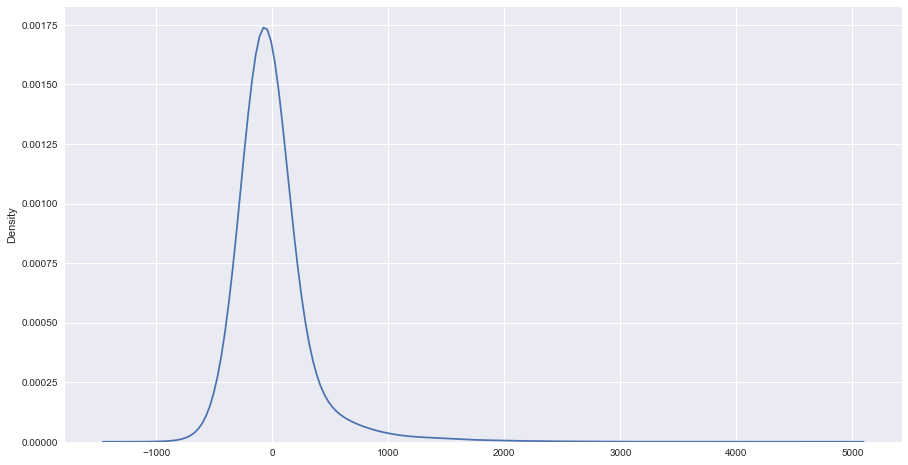

In [153]:
#plot the residual distribution
plt.figure(figsize = (15,8))
sns.kdeplot(np.array(results2.resid), bw_adjust = 5)
plt.show()

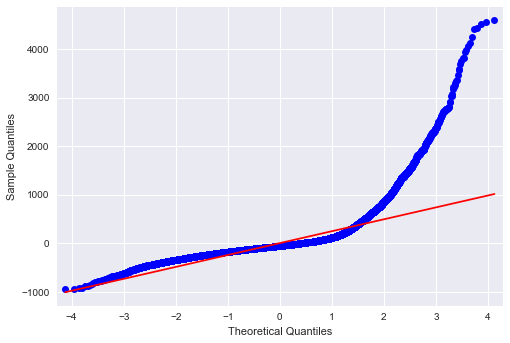

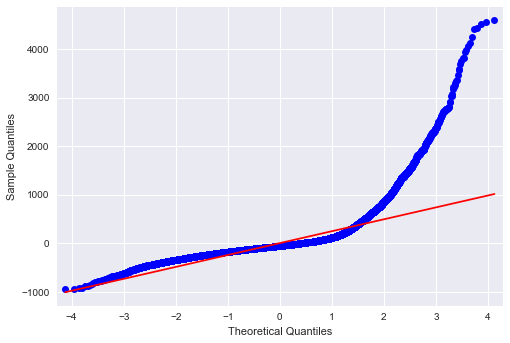

In [154]:
#qq-plot
sgg.qqplot(results2.resid, line = "r")

In [155]:
#tests of normality (test value, p-value)
print(stats.diagnostic.kstest_normal(results2.resid, pvalmethod='approx')) #Kolmogorov-Smirnov test
print(stats.diagnostic.normal_ad(results2.resid)) #Anderson-Darling test

(0.20432540538502442, 0.0)
(inf, 0.0)


C:\Users\Computer\anaconda3\envs\TMRenv\lib\site-packages\statsmodels\stats\_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


##### Part 2.2.3.1 Tests for Homoscedasticity & Linearity
The plot shows strong evidence for heteroscedasticity or a violation of the assumption of Homoscedasticity. It appears possible that the outliers with extremely high total revenue values resulted in overpredictions which explains those cases of extreme positive residuals. Additionally, there seems to be a linear pattern at the bottom left corner of the plot which is concerning. It seems that an increase in the predicted revenue was associated with a larger (positive) residual for these cases. It also showcases that the model makes a prediction of negative total revenue which is not actually possible and showcases a limitation of the model. 
Unsurprisingly, the tests both yield the same result.

In terms of linearity, this is difficult to establish given the obvious problems with the scatterplot.  It will need to be reexamined later on. 

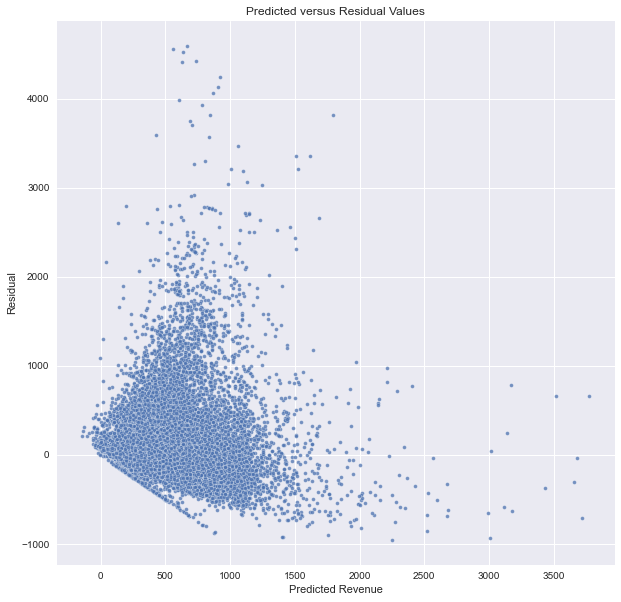

In [127]:
#plot the predicted values versus the residuals
plt.figure(figsize = (10,10))
sns.scatterplot(x = train_pred, y = results2.resid, alpha = 0.75, s = 15)
plt.xlabel("Predicted Revenue")
plt.ylabel("Residual")
plt.title("Predicted versus Residual Values")
plt.show()

In [128]:
#test for homoscedasticity (test, p, test, p)
stats.diagnostic.het_white(results2.resid, results2.model.exog)

(2191.8203057091014, 0.0, 10.995053709879969, 0.0)

##### Part 2.2.3.1 Tests for Collinearity
Maybe due to earlier efforts to reduce multicollinearity examing the correlation matrix, examining the VIF values shows very little issues with multicollinearity. The exception is age which showsa rather extreme VIF value, although it is not strongly correlated with any variable. It does show not-neglible correlations with a decent number of features (aysSinceCreation, AverageLeadTime, RoomNights, MarketDistribution2, MarketDistribution3, LodgingRevProp).

Aside from age, the main feature that stands out are the dummy variables for MarketDistribution which show some correlations with each other and LodgingRevProp.
It appears that there are some strong correlations between the Distribution Channel dummies and the Market Segment dummies which makes sense since these variables did have some similar although not identical categories. 

In terms of LodgingRevProp, this variable showed decent correlations with some of the variables mentioned prior. 

Based on this, one plan of action could be to exclude age and see whether this makes a difference to the model. 

In [129]:
y, X = dmatrices("TotalRevenue ~ Age + DaysSinceCreation + AverageLeadTime + RoomNights + TargetOrigin + DiffCreationFirstStay + DiffFirstLastStay + MarketDistribution1 + MarketDistribution2 + MarketDistribution3 + MarketDistribution4 + MarketDistribution5 + SRHighFloor + SRKingSizeBed + SRTwinBed + SRQuietRoom + MultipleBookings + NegativeOutcome + OtherPreferences + LodgingRevProp", data = Train_Set_TF2, return_type = "dataframe")
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [130]:
#examine each variable and its VIF
for i in range(len(vif)):
    print(round(vif[i],4), " ----- ", Train_Set_TF2.columns[i])

11691.8757  -----  Age
1.1117  -----  DaysSinceCreation
1.0576  -----  AverageLeadTime
1.2118  -----  RoomNights
1.1796  -----  TargetOrigin
1.0941  -----  DiffCreationFirstStay
1.0834  -----  DiffFirstLastStay
1.5061  -----  MarketDistribution1
5.5966  -----  MarketDistribution2
5.4298  -----  MarketDistribution3
11.6255  -----  MarketDistribution4
2.4449  -----  MarketDistribution5
6.4233  -----  Index
1.0253  -----  SRHighFloor
1.3132  -----  SRKingSizeBed
1.15  -----  SRTwinBed
1.0674  -----  SRQuietRoom
1.4277  -----  MultipleBookings
1.1233  -----  NegativeOutcome
1.0134  -----  OtherPreferences
1.1386  -----  LodgingRevProp


In [81]:
#reexamine correlation matrix
X.drop("Intercept", axis = 1).corr()

,Age,DaysSinceCreation,AverageLeadTime,RoomNights,TargetOrigin,DiffCreationFirstStay,DiffFirstLastStay,MarketDistribution1,MarketDistribution2,MarketDistribution3,MarketDistribution4,MarketDistribution5,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,MultipleBookings,NegativeOutcome,OtherPreferences,LodgingRevProp
Age,1.000000,0.054992,0.241567,0.014873,-0.042365,0.006234,0.007704,-0.040830,0.143723,-0.122593,-0.013027,0.095071,-0.035119,-0.009578,0.016408,0.016161,0.031414,0.007934,-0.037826,-0.175323
DaysSinceCreation,0.054992,1.000000,-0.050588,-0.023743,-0.042781,-0.015838,0.054265,-0.052451,-0.004678,0.012205,-0.037096,0.058527,-0.019270,-0.014874,-0.003986,-0.048609,-0.018763,0.014967,-0.011901,-0.159518
AverageLeadTime,0.241567,-0.050588,1.000000,0.126936,0.103136,0.034719,-0.052262,-0.105990,0.139420,-0.070947,-0.088245,0.173534,-0.014696,-0.008608,0.118536,0.016173,-0.052893,-0.033350,-0.019869,-0.188822
RoomNights,0.014873,-0.023743,0.126936,1.000000,0.185588,0.243052,0.174625,-0.045911,-0.048164,0.045095,-0.030059,0.058799,0.021419,0.050929,-0.007600,0.049040,0.156035,0.091155,0.026354,-0.025829
TargetOrigin,-0.042365,-0.042781,0.103136,0.185588,1.000000,0.049385,-0.070612,-0.057928,-0.092960,0.134023,-0.043776,0.031445,0.009159,0.020335,0.013892,0.069415,-0.075464,-0.038739,0.002464,0.039431
DiffCreationFirstStay,0.006234,-0.015838,0.034719,0.243052,0.049385,1.000000,0.109608,-0.007411,-0.011540,0.016809,-0.003767,0.001534,0.004961,0.014818,-0.009461,0.011170,0.018422,-0.049058,0.005455,-0.014859
DiffFirstLastStay,0.007704,0.054265,-0.052262,0.174625,-0.070612,0.109608,1.000000,0.007815,-0.023613,-0.067186,0.088099,-0.021142,-0.002263,0.025733,-0.016462,-0.010622,0.513631,0.299458,0.010301,-0.019367
MarketDistribution1,-0.040830,-0.052451,-0.105990,-0.045911,-0.057928,-0.007411,0.007815,1.000000,-0.136826,-0.421811,-0.073333,-0.155322,0.009269,-0.135174,-0.065534,-0.061689,0.005416,0.007432,0.057658,0.035432
MarketDistribution2,0.143723,-0.004678,0.139420,-0.048164,-0.092960,-0.011540,-0.023613,-0.136826,1.000000,-0.402942,-0.070052,-0.148374,-0.075156,-0.119022,0.061804,-0.108766,-0.012957,-0.013345,-0.040061,-0.082578
MarketDistribution3,-0.122593,0.012205,-0.070947,0.045095,0.134023,0.016809,-0.067186,-0.421811,-0.402942,1.000000,-0.215960,-0.457412,0.106334,0.362506,0.051927,0.224342,-0.087420,-0.047565,0.009258,0.162267


### Part 2.3 Model Improvements
Given the violated assumptions, one option was to exclude more outliers that had been detected. Specifically, due to the skew to the right, studentized residuals and DFFITS outliers above the respective boundaries were excluded. Afterwards, the model was refitted. The result was an improved R2 (0.546). However, the tests for normality and homeoscedasticity were still signifcant. For large datasets, the large power could contribute to this, but given the strong violations of the assumptions, it is equally likely that removing these outliers was not sufficient. 
The second option was to fit a robust model. While there is no R2 for the robust model, the reduced SE even compared to the model without outliers are evidence for the effectiveness of fitting a robust model over a regular model. Notable, are also some of the larger changes in the coefficients of some of the predictors, e.g., the valence changed for Age and the coefficient for DiffCreationFirstStay became very small. 
The plot showing the actual and predicted Revenue values for the original, the reduced, and the robust model do show that the reduced model looks most cohesive due to the exclusion of some of the extreme outliers. 

With this in mind, a final robust model will be fitted on the reduced dataset. 

In [175]:
#exclude more positive outliers
Train_Set_TF3 = Train_Set_TF.drop(index = Train_Set_Diag[(Train_Set_Diag["resid_student"] > 3) & (Train_Set_Diag["dffits"] > dffit_bound)].index)

Train_Set3 = Train_Set.drop(index = Train_Set_Diag[(Train_Set_Diag["resid_student"] > 3) & (Train_Set_Diag["dffits"] > dffit_bound)].index)

In [236]:
#fit a regular OLS regression model on the data after additional outliers were removed 
results3 = smf.ols("TotalRevenue ~ Age + DaysSinceCreation + AverageLeadTime + RoomNights + TargetOrigin + DiffCreationFirstStay + DiffFirstLastStay + MarketDistribution1 + MarketDistribution2 + MarketDistribution3 + MarketDistribution4 + MarketDistribution5 + SRHighFloor + SRKingSizeBed + SRTwinBed + SRQuietRoom + MultipleBookings + NegativeOutcome + OtherPreferences + LodgingRevProp", data = Train_Set_TF3).fit(method = "pinv")
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TotalRevenue   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     3190.
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        18:15:10   Log-Likelihood:            -3.5734e+05
No. Observations:               52966   AIC:                         7.147e+05
Df Residuals:                   52945   BIC:                         7.149e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               151.7301     95.913      1.582      0.114     -36.261     339.721
Age                     -14.7332      6.175     -2.386      0.017     -26.836      -2.631
DaysSinceCreation       -98.7756      3.328    -29.681      0.000    -105.298     -92.253
AverageLeadTime          26.4116      6.348      4.161      0.000      13.970      38.854
RoomNights             3416.8433     15.542    219.846      0.000    3386.381    3447.306
TargetOrigin             58.5669      4.350     13.464      0.000      50.041      67.093
DiffCreationFirstStay   213.6637    185.809      1.150      0.250    -150.524     577.851
DiffFirstLastStay      -430.3665     31.696    -13.578      0.000    -492.491    -368.243
MarketDistribution1      90.8639      6.346     14.319      0.000      78.426     103.302
MarketDistribution2     -14.5257      6.475     -2.243      0.025     -27.217      -1.834
MarketDistribution3      64.7458      6.083     10.643      0.000      52.823      76.669
MarketDistribution4     -39.6167      7.425     -5.335      0.000     -54.171     -25.063
MarketDistribution5     -76.2424      6.401    -11.910      0.000     -88.789     -63.696
SRHighFloor               7.7333      4.397      1.759      0.079      -0.885      16.352
SRKingSizeBed           -17.9080      2.154     -8.314      0.000     -22.130     -13.686
SRTwinBed                28.2100      2.800     10.075      0.000      22.722      33.698
SRQuietRoom              24.6820      3.307      7.464      0.000      18.201      31.163
MultipleBookings         97.2482      7.454     13.047      0.000      82.638     111.858
NegativeOutcome        -140.5307     20.930     -6.714      0.000    -181.554     -99.508
OtherPreferences         20.8877      6.508      3.209      0.001       8.131      33.644
LodgingRevProp          -93.7985      6.811    -13.772      0.000    -107.148     -80.449
==============================================================================
Omnibus:                    20713.044   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110254.646
Skew:                           1.824   Prob(JB):                         0.00
Kurtosis:                       9.054   Cond. No.                         413.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [238]:
#tests of normality (test value, p-value)
print(stats.diagnostic.kstest_normal(results3.resid, pvalmethod='approx')) #Kolmogorov-Smirnov test
print(stats.diagnostic.normal_ad(results3.resid)) #Anderson-Darling test

#test for homoscedasticity (test, p, test, p)
stats.diagnostic.het_white(results3.resid, results3.model.exog)

(0.15694069397784904, 0.0)
(2542.167890492048, 0.0)


(5710.2287625474855, 0.0, 30.797582684437767, 0.0)

In [246]:
#add intercept
features = sm.add_constant(Train_Set_TF2.loc[:,["Age", "DaysSinceCreation", "AverageLeadTime", "RoomNights", "TargetOrigin", "DiffCreationFirstStay", "DiffFirstLastStay", "MarketDistribution1", "MarketDistribution2", "MarketDistribution3", "MarketDistribution4", "MarketDistribution5", "SRHighFloor", "SRKingSizeBed", "SRTwinBed", "SRQuietRoom", "MultipleBookings", "NegativeOutcome", "OtherPreferences", "LodgingRevProp"]])

#fitting a robust model instead of excluding additional outliers
robust_results = sm.RLM(Train_Set_TF2.loc[:,"TotalRevenue"], features,  M=sm.robust.norms.HuberT()).fit()
robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           TotalRevenue   No. Observations:                53860
Model:                            RLM   Df Residuals:                    53839
Method:                          IRLS   Df Model:                           20
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 06 Dec 2021                                         
Time:                        18:22:01                                         
No. Iterations:                    21                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   266.4398     62.668      4.252      0.000     143.613     389.267
Age                       6.4302      3.984      1.614      0.107      -1.379      14.239
DaysSinceCreation      -101.2273      2.156    -46.955      0.000    -105.453     -97.002
AverageLeadTime         -10.9407      4.112     -2.661      0.008     -18.999      -2.882
RoomNights             3386.8916     10.164    333.213      0.000    3366.970    3406.813
TargetOrigin             40.9667      2.821     14.522      0.000      35.438      46.496
DiffCreationFirstStay    28.2532    121.409      0.233      0.816    -209.705     266.211
DiffFirstLastStay      -250.9647     20.913    -12.000      0.000    -291.954    -209.976
MarketDistribution1      84.5475      4.142     20.414      0.000      76.430      92.665
MarketDistribution2      -1.8484      4.224     -0.438      0.662     -10.127       6.430
MarketDistribution3      72.9762      3.975     18.357      0.000      65.184      80.768
MarketDistribution4      -3.4045      4.852     -0.702      0.483     -12.915       6.106
MarketDistribution5     -50.6472      4.182    -12.111      0.000     -58.844     -42.451
SRHighFloor              12.9508      2.848      4.548      0.000       7.370      18.532
SRKingSizeBed           -12.9682      1.394     -9.302      0.000     -15.701     -10.236
SRTwinBed                17.5976      1.808      9.732      0.000      14.053      21.142
SRQuietRoom              16.6699      2.133      7.814      0.000      12.489      20.851
MultipleBookings         53.3138      4.887     10.909      0.000      43.735      62.893
NegativeOutcome         -61.7187     13.925     -4.432      0.000     -89.012     -34.425
OtherPreferences         11.5711      4.248      2.724      0.006       3.246      19.897
LodgingRevProp         -158.1042      4.418    -35.784      0.000    -166.764    -149.444
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

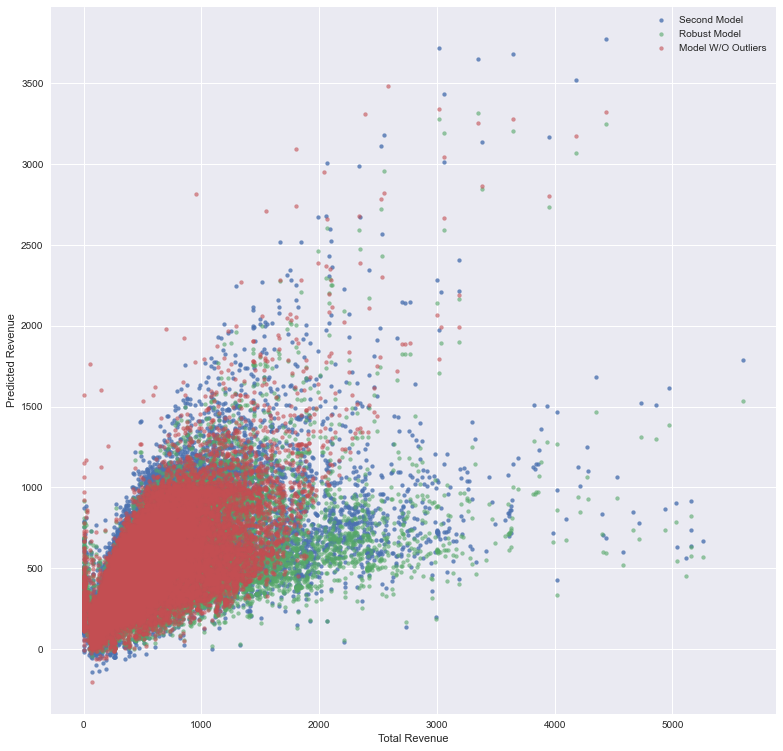

In [248]:
#plotting the difference between the inital second model (with violated assumptions), the robust model, and the model with additional outliers excluded
plt.figure(figsize=(13,13))
plt.scatter(Train_Set_TF2["TotalRevenue"], results2.predict(), alpha = 0.8, s = 15, label = "Second Model")
plt.scatter(Train_Set_TF2["TotalRevenue"], robust_results.predict(), alpha = 0.6, s = 15, label = "Robust Model")
plt.scatter(Train_Set_TF3["TotalRevenue"], results3.predict(), alpha = 0.6, s = 15, label = "Model W/O Outliers")
plt.xlabel("Total Revenue")
plt.ylabel("Predicted Revenue")
plt.legend()
plt.show()

### Part 2.4 Final Model & Evaluation
#### Part 2.4.1 Fitting & Examining the final Model
With the previous analyses in mind, the final robust OLS model will be fitted on the reduced data (where the additional outliers were removed). Next, the non-signifcant predictors as well as Age (due to the extreme VIF value) were excluded. This did not change the other coefficients or their SE. 
It was was interesting to see that the average lead time, the difference in days between creation and the first stay, and falling into the Groups & Travel Agent or Rest Market Segment & Distribution Channel all were not signifcant. This makes most sense with the combined groups of the MarketDistribution variable which could have simply been to diverse. 

<br>
Now, a closer look can be taken at the role of each feature. In general, there are slightly more positive than negative predictors, and one predictor with a much larger coefficient than the other variables. 
In terms of negative predictors, we observe that an increase in the number of days since account creation, in the number of days between the first and the last stay, in the proportion of revenue obtained from lodging all are associated with a decrease in the total revenue. It was observed earlier that revenue had increased for more recent customers compared to earlier customers. However, it seems odd that a larger proportion of revenue obtained from lodging would be associated with a larger total revenue. Aside from this, falling into the Market Segment & Distribution Channel of Travel Agent, asking for a KingSized Bed, or having ever cancelled or not shown for a booking are all associated with a lower total revenue. The latter relationship is the most intuitive. Notably, these relationships are all considered while controlling for the other variables. 

 <br>
Concerning the positive predictors, it appears that the number of nights and/or rooms booked is very strongly positively related to the total revenue. Aside from this, there is a relationship between origin and total revenue as the TargetOrigin variable is positively related Total Revenue. Some of the origins associated with a higher total revenue are  Africa, Belgium, Other within Europe, Netherlands, and Sweden. Some of the origins associated with a lower total revenue are Portugal and North America. Moving on, falling into the Director or Other & Travel Agent Market Segment & Distribution Channel, asking for a high floor, a twin bed, or a quiet room, having multiple bookings, and having voiced other prefences all are associated with an increased total revenue. 


<br>
When plotting the actual versus the predicted values using this final model, two things stand out: Firstly, there are still customers in the dataset with an (unexpected) total Revenue of 0 (despite having completed at least one booking). Natuarally, these customers total revenue was overpredicted. Secondly, the scatterplot shows a cone shaped pattern that does follow a 45 degree line. This ilustrates both the assumptions that could not be met as well as the moderate performance of the model. 

In [249]:
#add intercept
features = sm.add_constant(Train_Set_TF3.loc[:,["Age", "DaysSinceCreation", "AverageLeadTime", "RoomNights", "TargetOrigin", "DiffCreationFirstStay", "DiffFirstLastStay", "MarketDistribution1", "MarketDistribution2", "MarketDistribution3", "MarketDistribution4", "MarketDistribution5", "SRHighFloor", "SRKingSizeBed", "SRTwinBed", "SRQuietRoom", "MultipleBookings", "NegativeOutcome", "OtherPreferences", "LodgingRevProp"]])

#fitting a robust model instead of excluding additional outliers
final_robust_results = sm.RLM(Train_Set_TF3.loc[:,"TotalRevenue"], features,  M=sm.robust.norms.HuberT()).fit()
final_robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           TotalRevenue   No. Observations:                52966
Model:                            RLM   Df Residuals:                    52945
Method:                          IRLS   Df Model:                           20
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 06 Dec 2021                                         
Time:                        18:37:09                                         
No. Iterations:                    20                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   246.6347     59.646      4.135      0.000     129.730     363.539
Age                      13.6103      3.840      3.544      0.000       6.084      21.136
DaysSinceCreation       -98.3582      2.070    -47.526      0.000    -102.414     -94.302
AverageLeadTime         -11.2295      3.948     -2.845      0.004     -18.967      -3.492
RoomNights             3289.6542      9.665    340.362      0.000    3270.711    3308.598
TargetOrigin             41.9712      2.705     15.516      0.000      36.669      47.273
DiffCreationFirstStay    56.7738    115.550      0.491      0.623    -169.700     283.248
DiffFirstLastStay      -241.1810     19.711    -12.236      0.000    -279.814    -202.548
MarketDistribution1      80.9296      3.946     20.508      0.000      73.195      88.664
MarketDistribution2      -2.2657      4.027     -0.563      0.574     -10.158       5.627
MarketDistribution3      71.9796      3.783     19.027      0.000      64.565      79.394
MarketDistribution4      -1.1330      4.618     -0.245      0.806     -10.183       7.918
MarketDistribution5     -46.8227      3.981    -11.762      0.000     -54.625     -39.020
SRHighFloor              14.2864      2.734      5.225      0.000       8.927      19.646
SRKingSizeBed           -11.5523      1.339     -8.624      0.000     -14.178      -8.927
SRTwinBed                16.0666      1.741      9.227      0.000      12.654      19.479
SRQuietRoom              15.8241      2.056      7.695      0.000      11.794      19.854
MultipleBookings         55.4785      4.635     11.968      0.000      46.393      64.564
NegativeOutcome         -65.8675     13.016     -5.061      0.000     -91.378     -40.357
OtherPreferences         16.7104      4.047      4.129      0.000       8.778      24.643
LodgingRevProp         -156.2952      4.235    -36.902      0.000    -164.597    -147.994
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [250]:
#exclude not-signifcant predictors using a multiple comparison adjustment: alpha = 0.05/20
#Age, ALT, DiffCreationFirstStay, MarketDistribution2, MarketDistribution4

#add intercept
features = sm.add_constant(Train_Set_TF3.loc[:,["DaysSinceCreation", "RoomNights", "TargetOrigin",  "DiffFirstLastStay", "MarketDistribution1", "MarketDistribution3", "MarketDistribution5", "SRHighFloor", "SRKingSizeBed", "SRTwinBed", "SRQuietRoom", "MultipleBookings", "NegativeOutcome", "OtherPreferences", "LodgingRevProp"]])

#fitting a robust model instead of excluding additional outliers
final_robust_results = sm.RLM(Train_Set_TF3.loc[:,"TotalRevenue"], features,  M=sm.robust.norms.HuberT()).fit()
final_robust_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           TotalRevenue   No. Observations:                52966
Model:                            RLM   Df Residuals:                    52950
Method:                          IRLS   Df Model:                           15
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 06 Dec 2021                                         
Time:                        18:50:13                                         
No. Iterations:                    19                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 279.3715      3.929     71.108      0.000     271.671     287.072
DaysSinceCreation     -97.7188      2.059    -47.450      0.000    -101.755     -93.682
RoomNights           3286.9550      9.368    350.867      0.000    3268.594    3305.316
TargetOrigin           41.0936      2.690     15.274      0.000      35.820      46.367
DiffFirstLastStay    -238.3865     19.496    -12.227      0.000    -276.599    -200.174
MarketDistribution1    82.7406      2.092     39.558      0.000      78.641      86.840
MarketDistribution3    73.4751      1.670     43.991      0.000      70.201      76.749
MarketDistribution5   -45.5614      2.011    -22.659      0.000     -49.502     -41.620
SRHighFloor            14.1430      2.737      5.168      0.000       8.779      19.507
SRKingSizeBed         -11.6517      1.336     -8.719      0.000     -14.271      -9.032
SRTwinBed              15.5267      1.724      9.006      0.000      12.148      18.906
SRQuietRoom            16.1210      2.055      7.844      0.000      12.093      20.149
MultipleBookings       56.7035      4.583     12.372      0.000      47.720      65.687
NegativeOutcome       -65.0221     12.917     -5.034      0.000     -90.340     -39.705
OtherPreferences       16.5316      4.049      4.083      0.000       8.596      24.467
LodgingRevProp       -155.9590      4.124    -37.817      0.000    -164.042    -147.876
=======================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

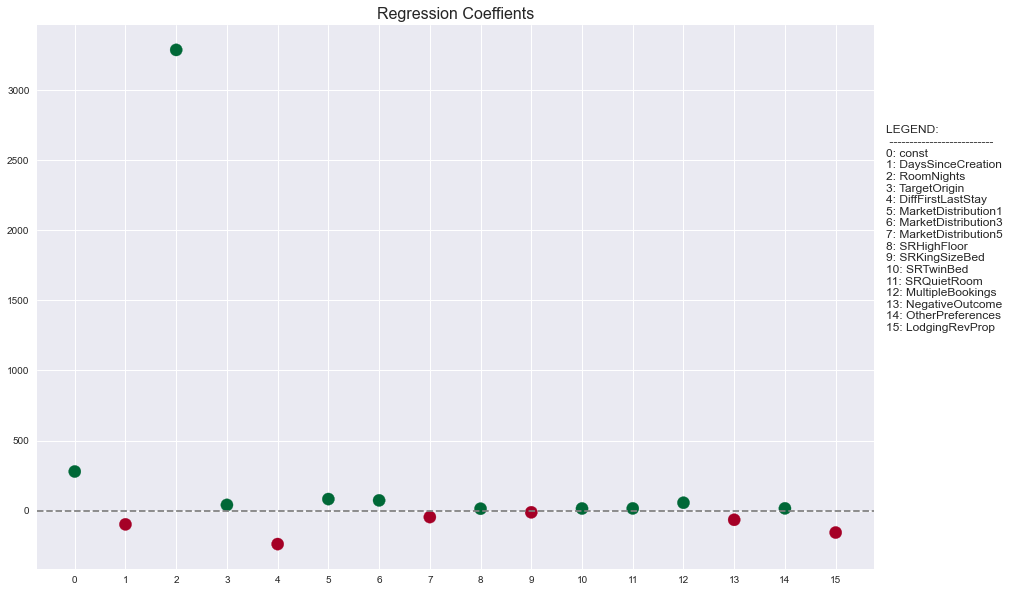

In [304]:
#visualise regression coefficients
plt.rc('font', size = 12)
plt.figure(figsize = (15,10))
plt.scatter(range(len(final_robust_results.params)), final_robust_results.params, c = np.sign(final_robust_results.params), s = 150 ,cmap = "RdYlGn")
plt.title("Regression Coeffients", fontsize = 16)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #adds a line at zero

text = 'LEGEND: \n -------------------------- \n'
for i, value in enumerate(final_robust_results.params.index.tolist()):
    if i < len(final_robust_results.params.index.tolist()) : text = text + str(i) + ': ' + value + '\n'
    else: text = text + str(i) + ': ' + value

plt.xticks(range(0,16))

plt.text(16, 1200, text)
plt.show()

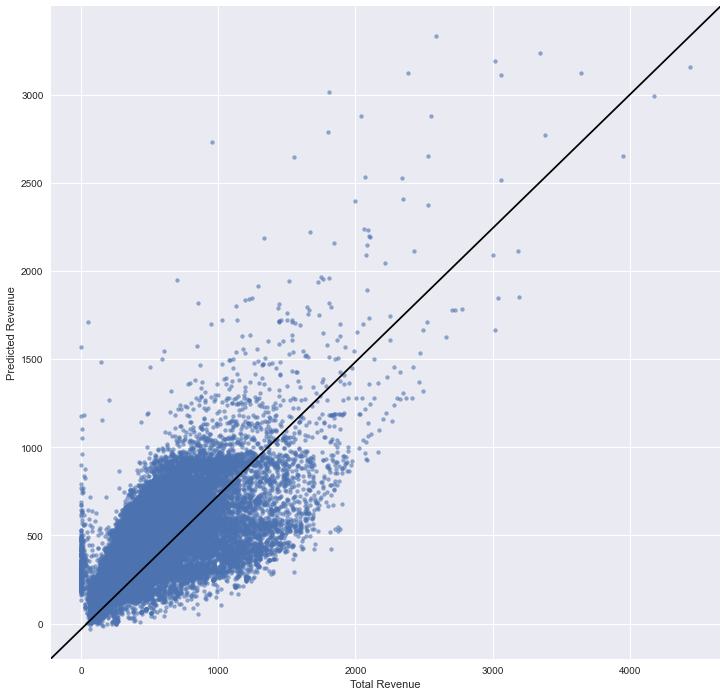

In [323]:
#plotting the predicted and actual train scores for the final model
f, ax = plt.subplots(figsize=(12, 12))
#plt.figure(figsize=(13,13))
ax.scatter(Train_Set_TF3["TotalRevenue"], final_robust_results.predict(), alpha = 0.6, s = 15)
ax.set_xlabel("Total Revenue")
ax.set_ylabel("Predicted Revenue")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, c = "black")

plt.show()

#### Part 2.4.2. Testing & Evaluating the final Model
Using the final robust model, the test data set will be used for a final evaluation. For this to work, the test set will be adjusted by excluding the variables that were excluded from the model and added the constant. After using the model to predict the total revenue, the mean squared error, mean absolute error, and R2 were computed. 
In general, performance on the test set is substantially lower as on the training set. This makes somewhat sense, as the improvements to the final model were based on violated assumptions and without the ability to check R2. Hence, it is possible that adjustments after the grid search only improved performance on the training set.
The plot also shows that for a large part of the dataset, the revenue was overpredicted, while it was underpredicted for customers with a more extreme total revenue. 

Out of curiosity, some of these extreme customers were excluded (in line with the steps taken to fit the final model) to see whether this would improve the quality of predictions. Indeed, the evaluation metrics were improved. 

In [488]:
#adjust the test set by excluding the irrelevant columns
X_test2 = X_test.drop(["Age", "AverageLeadTime", "DiffCreationFirstStay"], axis = 1)
X_test_TF2 = X_test_TF.drop(["Age", "AverageLeadTime", "DiffCreationFirstStay", "MarketDistribution2", "MarketDistribution4", "Index"], axis = 1)

In [489]:
X_test_TF2_constant = sm.add_constant(X_test_TF2)
test_pred = final_robust_results.predict(X_test_TF2_constant)

In [604]:
#evaluation metrics
print("Mean Squared Error: ", ste.mse(test_pred, y_test.iloc[:,1]))
print("Mean Absolute Error: ", ste.meanabs(test_pred, y_test.iloc[:,1]))
print("R2 as the proportion of explained variance contrasted with the total variance: ", ((np.std(y_test)[1]) ** 2 - ste.mse(test_pred, y_test.iloc[:,1]))/((np.std(y_test)[1]) ** 2))

Mean Squared Error:  112759.93813489388
Mean Absolute Error:  161.009974619531
R2 as the proportion of explained variance contrasted with the total variance:  0.35976838133607825


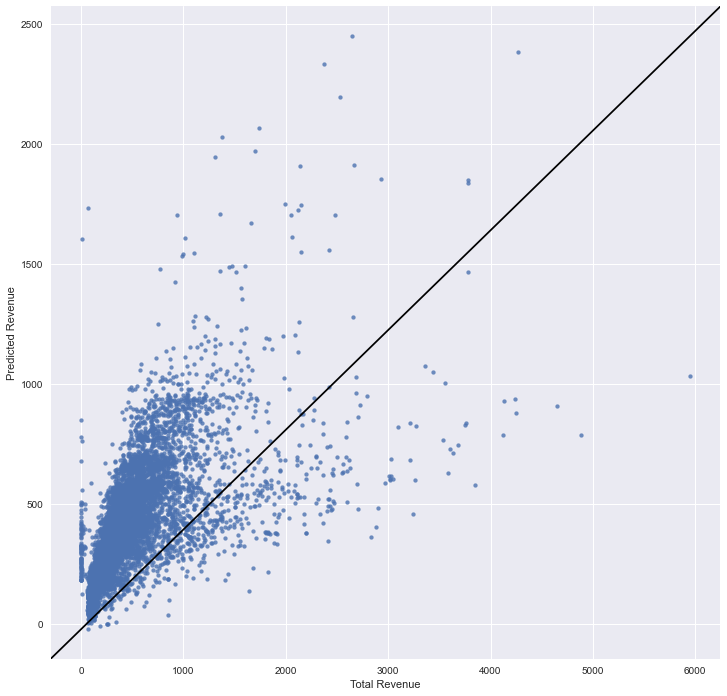

In [491]:
#plotting the predicted and actual test scores for the final model
f, ax = plt.subplots(figsize=(12, 12))
#plt.figure(figsize=(13,13))
ax.scatter(y_test.iloc[:,1], test_pred, alpha = 0.8, s = 15)
ax.set_xlabel("Total Revenue")
ax.set_ylabel("Predicted Revenue")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, c = "black")

plt.show()

In [587]:
#identify customers with a very high Total Revenue and a very high Total Revenue by Night
Test_Set = X_test.merge(y_test, how = "left", left_on = "index", right_on = "index")
Test_Set[(Test_Set["Rev_By_RN"] > Test_Set["Rev_By_RN"].quantile(0.99)) & 
    (Test_Set["TotalRevenue"] > Test_Set["TotalRevenue"].quantile(0.99))].head()

,index,Age,DaysSinceCreation,AverageLeadTime,RoomNights,SRHighFloor,SRKingSizeBed,SRTwinBed,SRQuietRoom,TargetOrigin,MultipleBookings,NegativeOutcome,OtherPreferences,MarketDistribution,LodgingRevProp,DiffCreationFirstStay,DiffFirstLastStay,TotalRevenue,Rev_By_RN
251,58077,35.0,97,21,4,0,0,0,0,375.188045,0,0,0,Groups & Travel Agent,0.964774,4,0,2413.0,603.250000
550,19346,66.0,731,173,4,0,1,0,0,342.832093,0,0,0,Direct,0.884393,4,0,2595.0,648.750000
1108,29490,48.0,561,278,4,1,0,1,0,375.188045,0,0,0,Other & Travel Agent,0.741990,4,0,2965.0,741.250000
1667,58091,35.0,97,21,4,0,0,0,0,420.000529,0,0,0,Groups & Travel Agent,0.931474,4,0,2473.5,618.375000
2091,58151,35.0,96,20,6,0,1,0,0,375.188045,0,0,0,Groups & Travel Agent,0.961480,6,0,3631.9,605.316667


In [572]:
#removing extreme outliers
X_test_TF_red = X_test_TF.drop(index = Test_Set[
    (Test_Set["Rev_By_RN"] > Test_Set["Rev_By_RN"].quantile(0.99)) & 
    (Test_Set["TotalRevenue"] > Test_Set["TotalRevenue"].quantile(0.99))
    ].index, axis = 0)

X_test_TF_red = X_test_TF_red.drop(["Age", "AverageLeadTime", "DiffCreationFirstStay", "MarketDistribution2", "MarketDistribution4", "Index"], axis = 1)

In [575]:
#adjusting the target variable to reflect the removed outliers
y_test_red = Test_Set["TotalRevenue"].drop(index = Test_Set[
    (Test_Set["Rev_By_RN"] > Test_Set["Rev_By_RN"].quantile(0.99)) & 
    (Test_Set["TotalRevenue"] > Test_Set["TotalRevenue"].quantile(0.99))
    ].index, axis = 0)

X_test_TF_red_constant = sm.add_constant(X_test_TF_red)
test_red_pred = final_robust_results.predict(X_test_TF_red_constant)

In [603]:
#evaluation metrics after removing extreme customers
print("Mean Squared Error: ", ste.mse(test_red_pred, y_test_red))
print("Mean Absolute Error: ", ste.meanabs(test_red_pred, y_test_red))
print("R2 as the proportion of explained variance contrasted with the total variance: ", (   (np.std(y_test_red) ** 2) - ste.mse(test_red_pred, y_test_red)   )/(np.std(y_test_red) ** 2) )

Mean Squared Error:  85927.79863614826
Mean Absolute Error:  151.57984088185736
R2 as the proportion of explained variance contrasted with the total variance:  0.41186969603251555


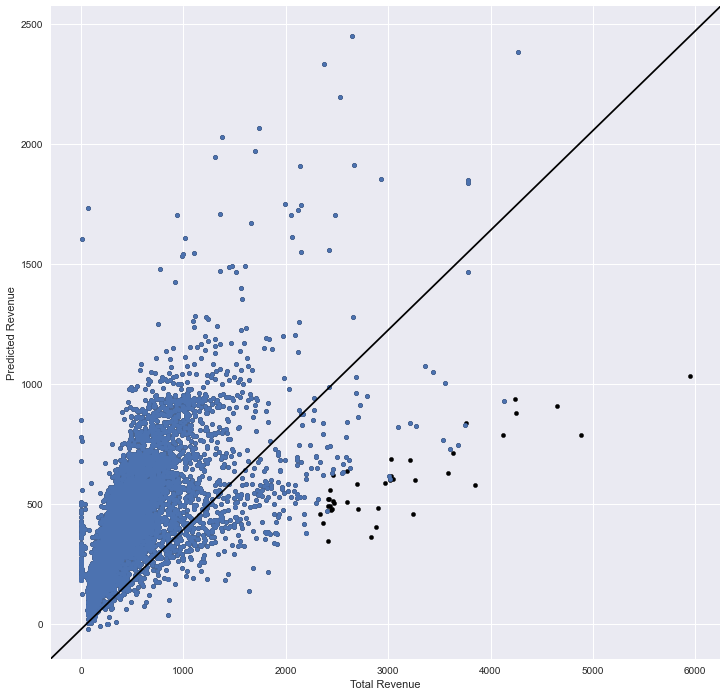

In [602]:
#visualising the removed outliers by showing the predictions before and after
f, ax = plt.subplots(figsize=(12, 12))
#plt.figure(figsize=(13,13))
ax.scatter(y_test.iloc[:,1], test_pred, alpha = 1, s = 19, c = "black")
ax.scatter(y_test_red, test_red_pred, alpha = 1, s = 20)
ax.set_xlabel("Total Revenue")
ax.set_ylabel("Predicted Revenue")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, c = "black")

plt.show()

### Final Comments
This project was done for the main reason of practicing my data analysis and statistics skills. In this process, some decisions were made in line with this overarching goal. Additionally, machine learning and statistics often approach these analyses differently which can lead to incompatible decisions. From a machine learning standpoint, it surely would have been possible to generate a much better final model. From a statistical perspective, this should have been ideally approached with theories and hypotheses in mind to avoid unethical data snooping. 

Aside from this, excluding customers without bookings in the beginning resulted in a smaller R2 as the variance in the outcome variable was reduced. However, it does not make sense to predict total revenue for customers that never stayed at the hotel. 
On another note, in hindsight it is obvious that the order of steps could likely be improved. For instance, changes were only applied to the training set which meant they had to be repeated for the test set. 